In [451]:
## Imports
import json
import os, sys
import time
import yaml
import h5py
import pickle
import numpy as np
import collections
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

#from cGANtools.GAN import CGAN
#from keras.models import load_model
from itertools import combinations
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.insert(0, parent_dir)
import helper as hp

In [452]:
def count_occurrences(names):
    return dict(sorted(collections.Counter(names).items(), key=lambda x: x[1], reverse=True))

def consolidate_dicts(dict_list):
    all_keys = set(key for d in dict_list for key in d)
    consolidated = {key: [d.get(key, 0) for d in dict_list] for key in all_keys}
    consolidated = dict(sorted(consolidated.items(), key=lambda x: sum(x[1]), reverse=True))
    return consolidated

def consolidate_dicts_remove_zeros(dict_list):
    all_keys = set(key for d in dict_list for key in d)
    consolidated = {key: [d.get(key, 0) for d in dict_list] for key in all_keys}
    # Remove entries with at least one zero in their values
    consolidated = {key: values for key, values in consolidated.items() if 0 not in values}
    consolidated = dict(sorted(consolidated.items(), key=lambda x: sum(x[1]), reverse=True))    
    return consolidated


### Get top $n$ KM candidates for each model in each steady state

In [453]:
ss = [0,2,4,5]
n_top = 3

for ss_idx in ss:
    
    ixs = pd.read_csv(f'analysis/{ss_idx}/ixs.csv').iloc[:, 1].values   #valid indexes for models generated in this steady state
    og_max_eigs = pd.read_csv(f'analysis/{ss_idx}/sample_max_eig.csv').iloc[:,1].values # max eigs of valid models
    
    info = pd.DataFrame(columns = ['lambda_max', 'tau_max', 'imp_kms'])
    
    for i,ix in enumerate(ixs):
        
        sample_eig = og_max_eigs[ix]
        sample_tau = -60/sample_eig

        causation = pd.read_csv(f'analysis/{ss_idx}/km_heatmap/{ix}/causation_ix.csv')
        causation_effects = causation.iloc[:,-1].values

        '''
        low_imp_ix = np.where(sum_of_effects > (1 - 1e-5))[0][0]  # discarding Kms with low effect
        imp_kms = causation['name'].values[:low_imp_ix]
        '''

        imp_kms = causation['name'].values[-n_top:]
        info.loc[i] = [sample_eig, sample_tau, imp_kms]
    info = info.sort_values(by = 'tau_max')
    info.to_csv(f'analysis/{ss_idx}/important_kms_{n_top}.csv')

## Global Analysis

### 1. Check highest occurences of enzymes for each steady state

In [454]:
ss = [0,2,4,5]
list_of_dicts = []

for ss_idx in ss:

    og_max_eigs = pd.read_csv(f'analysis/{ss_idx}/sample_max_eig.csv').iloc[:,1].values
    valid_no = len(np.where(og_max_eigs<0)[0])
    km_data = pd.read_csv(f'analysis/{ss_idx}/important_kms_{n_top}.csv')
    all_ixs = km_data.iloc[:,0].values
    imp_rxns = []
    
    for this_ix in all_ixs:
        
        these_imp_kms = km_data.iloc[this_ix]['imp_kms']
        cleaned_string = these_imp_kms.strip("[]").replace("\n", "")
        elements_list = cleaned_string.split()

        for this_km in elements_list:
            
            _,_,rxn = this_km.split('_',2)
            if 'LMPD' in rxn: imp_rxns.append('Biomass')
            else: imp_rxns.append(rxn[:-1])

    occurrences = count_occurrences(imp_rxns)
    occurrences = {key: value*100/ valid_no for key, value in occurrences.items()}
    list_of_dicts.append(occurrences)

all_occurrences = consolidate_dicts(list_of_dicts)

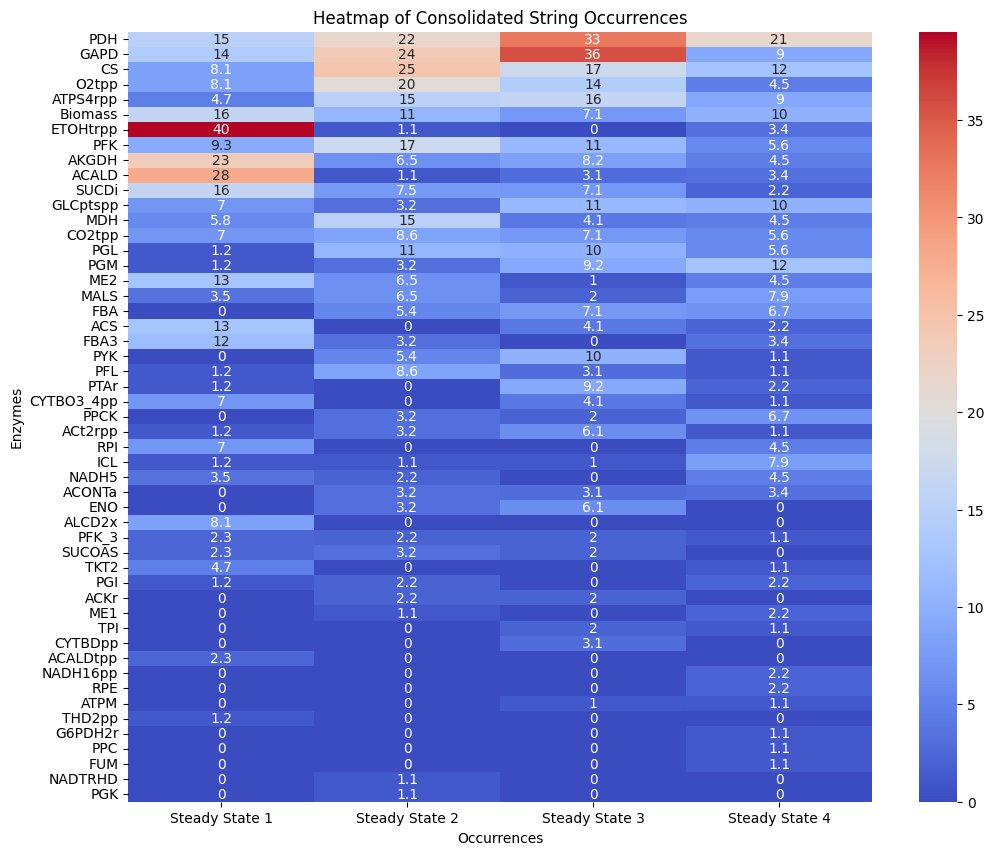

In [455]:
labels = list(consolidated_dict.keys())
values = np.array(list(consolidated_dict.values()))

plt.figure(figsize=(12, 10))
sns.heatmap(values, annot=True, cmap='coolwarm', xticklabels=[f'Steady State {i+1}' for i in range(values.shape[1])], yticklabels=labels)
plt.xlabel('Occurrences')
plt.ylabel('Enzymes')
plt.title('Heatmap of Consolidated String Occurrences')
plt.savefig(f'figures/figure 4/global_all_enzymes.svg', dpi=300, transparent=False, bbox_inches='tight')
plt.savefig(f'figures/figure 4/global_all_enzymes.png', dpi=300, transparent=False, bbox_inches='tight')
plt.show()

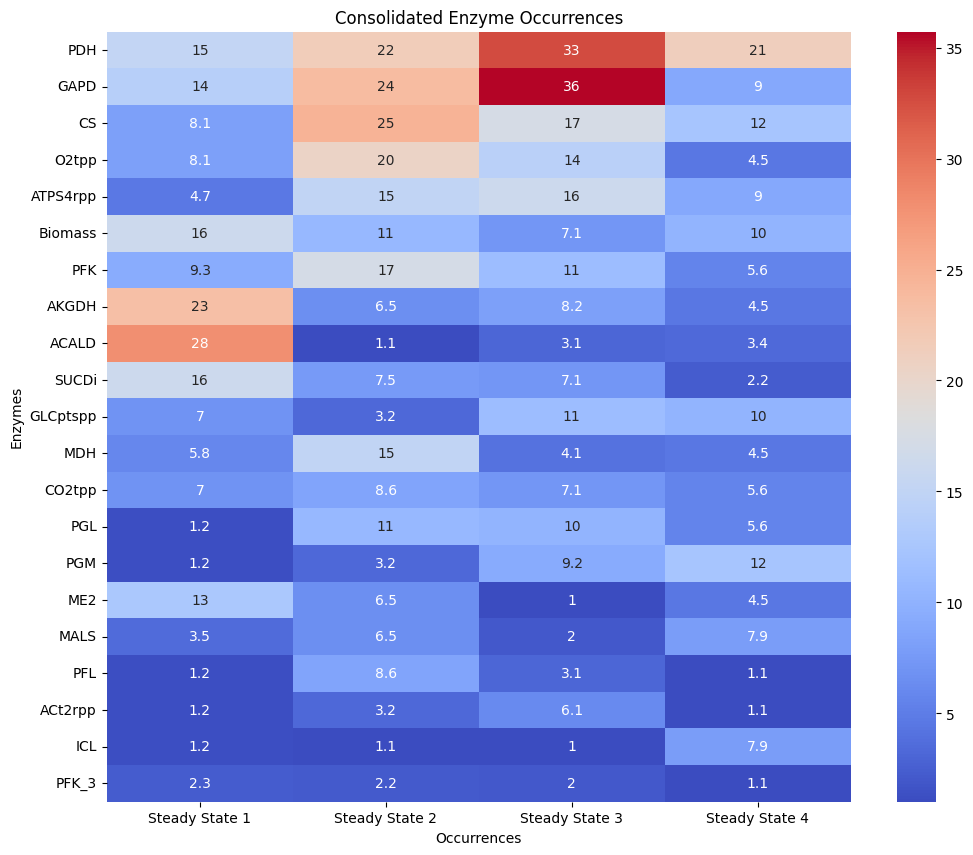

In [456]:
new_consolidated_dict = consolidate_dicts_remove_zeros(list_of_dicts)
labels = list(new_consolidated_dict.keys())
values = np.array(list(new_consolidated_dict.values()))
pd.DataFrame(labels).to_csv(f'analysis/global/global_enzymes.csv')
plt.figure(figsize=(12, 10))
sns.heatmap(values, annot=True, cmap='coolwarm', xticklabels=[f'Steady State {i+1}' for i in range(values.shape[1])], yticklabels=labels)
plt.xlabel('Occurrences')
plt.ylabel('Enzymes')
plt.title('Consolidated Enzyme Occurrences')
plt.savefig(f'figures/figure 4/global_selected_enzymes.svg', dpi=300, transparent=False, bbox_inches='tight')
plt.savefig(f'figures/figure 4/global_selected_enzymes.png', dpi=300, transparent=False, bbox_inches='tight')
plt.show()

pd.DataFrame(list(new_consolidated_dict.keys())[:10]).to_csv(f'analysis/global/top_enzymes.csv')

### 2. Global sensitivity analysis

In [468]:
important_enzymes = pd.read_csv(f'analysis/global/global_enzymes.csv').iloc[:,1].values
names_km = pd.read_csv('../models/varma_ecoli_small/parameter_names_km_fdp1.csv').iloc[:,1].values

# get KMs associated with importnat enzymes
n_enzymes = 3
important_kms = []
for this_enzyme in important_enzymes[:n_enzymes]:
    for this_km_name in names_km: 
        if '_'+this_enzyme in this_km_name: important_kms.append(this_km_name)
indexes = []
for this_km in important_kms:
    indexes.append(np.where(np.array(names_km) == this_km)[0][0])
pd.DataFrame(np.transpose(np.vstack((indexes, important_kms))), columns = ['1','2']).to_csv(f'analysis/global/global_kms.csv')

In [469]:
## Now change globally important Kms in the original samples
important_kms = pd.read_csv(f'analysis/global/global_kms.csv').iloc[:,1].values
important_km_names = pd.read_csv(f'analysis/global/global_kms.csv').iloc[:,2].values

for this_km, this_name in zip(important_kms, important_km_names):

    this_path = f'analysis/global/{this_name}'
    os.makedirs(this_path, exist_ok = True)

    for ss_idx in ss:

        og_max_eigs = pd.read_csv(f'analysis/{ss_idx}/sample_max_eig.csv').iloc[:,1].values
        og_sample = np.load(f'analysis/{ss_idx}/sample.npy')

        # increase Km by 100%
        dummy_sample = og_sample.copy()
        dummy_sample[:, this_km] *= 4  
        np.save(f'{this_path}/sample_{ss_idx}_ddouble.npy', dummy_sample)

        # decrease Km by 100%
        dummy_sample = og_sample.copy()
        dummy_sample[:, this_km] /= 4  
        np.save(f'{this_path}/sample_{ss_idx}_hhalf.npy', dummy_sample)

In [470]:
important_km_names

array(['km_substrate1_PDH', 'km_product1_PDH', 'km_substrate2_PDH',
       'km_product2_PDH', 'km_substrate3_PDH', 'km_product3_PDH',
       'km_substrate1_GAPD', 'km_product1_GAPD', 'km_substrate2_GAPD',
       'km_product2_GAPD', 'km_substrate3_GAPD', 'km_substrate1_CS',
       'km_product1_CS', 'km_substrate2_CS', 'km_product2_CS'],
      dtype=object)

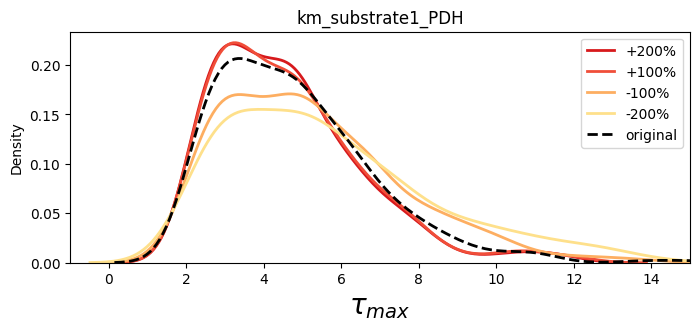

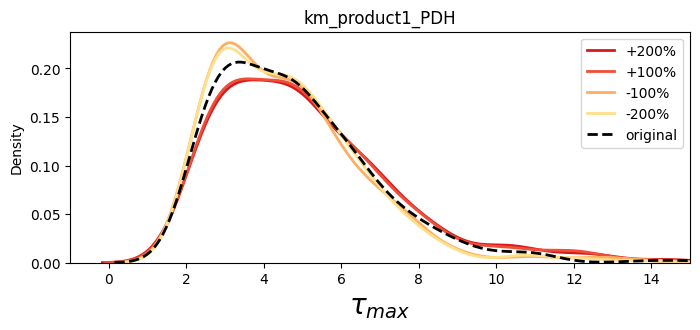

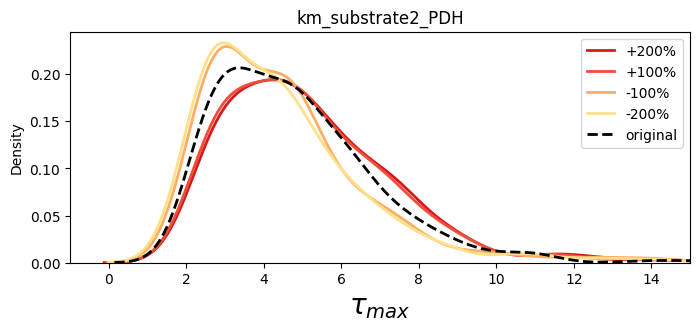

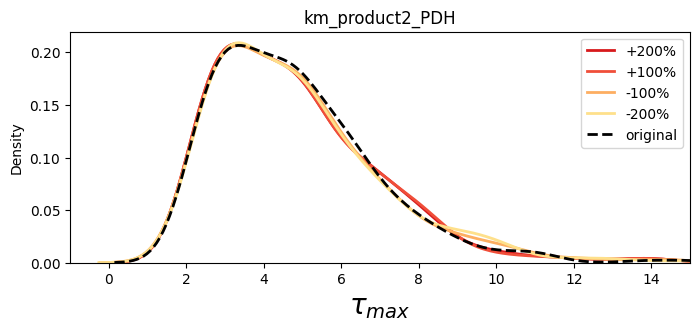

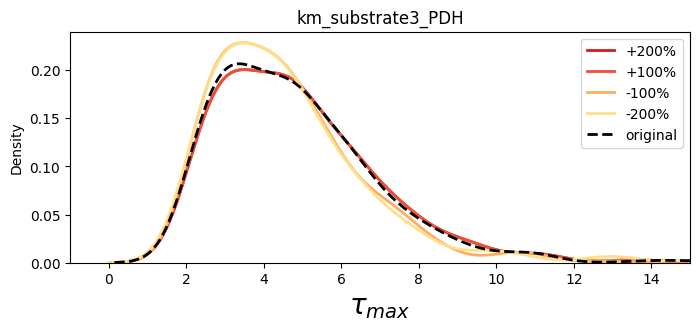

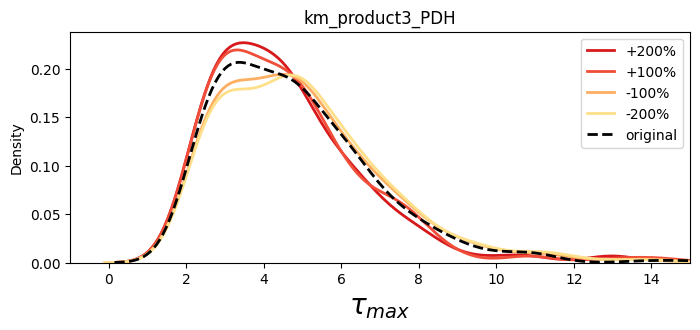

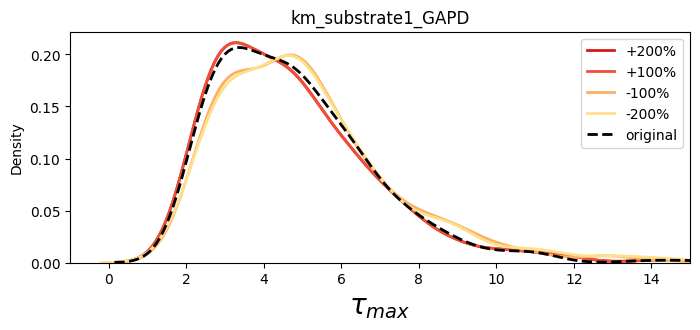

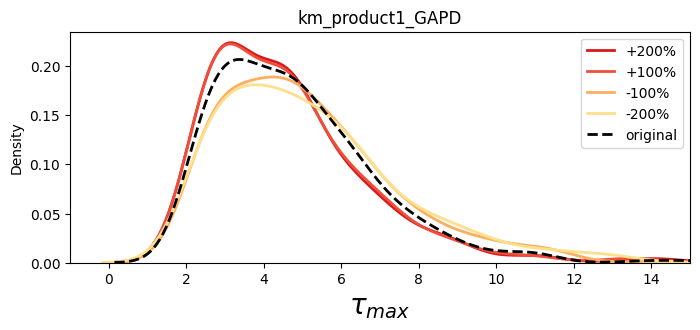

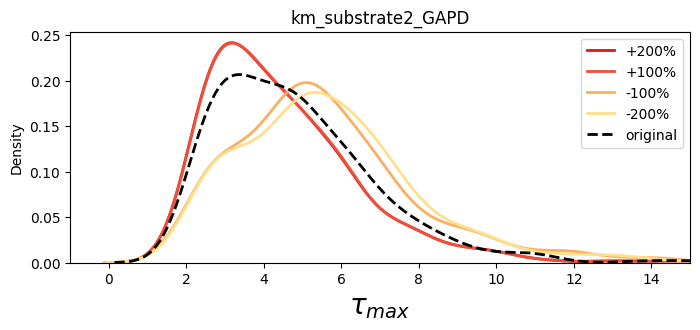

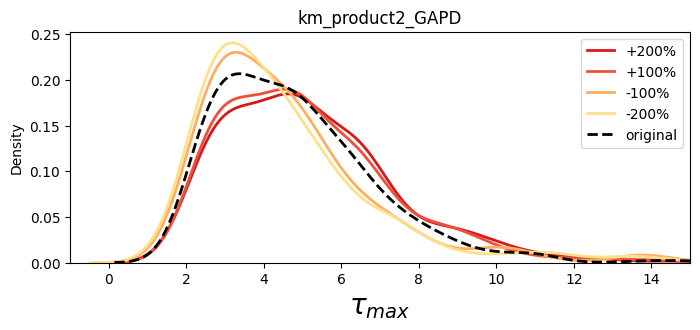

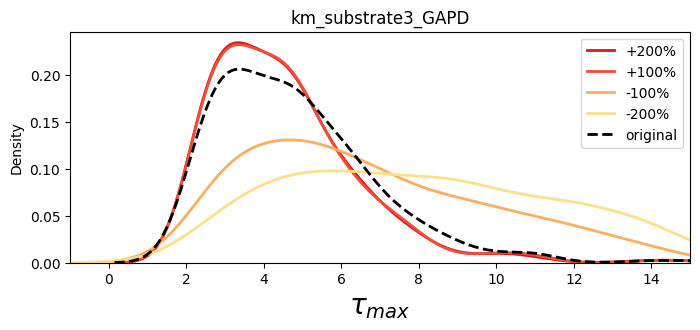

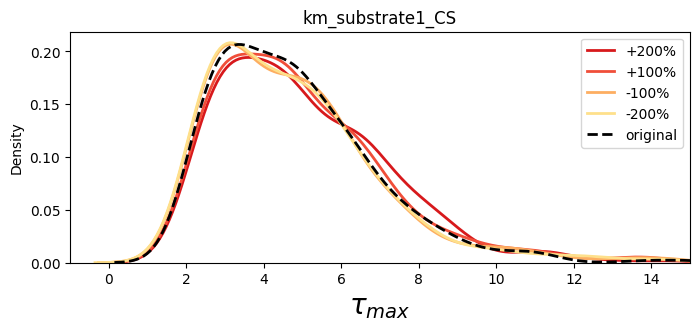

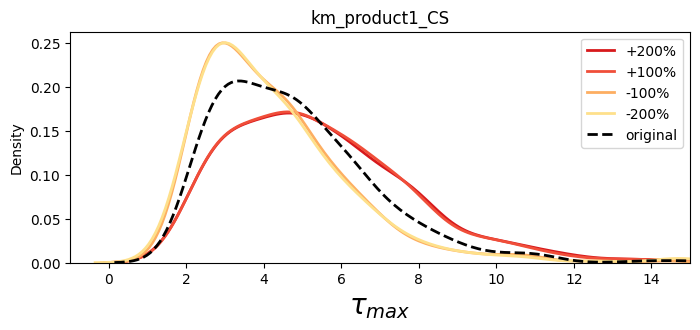

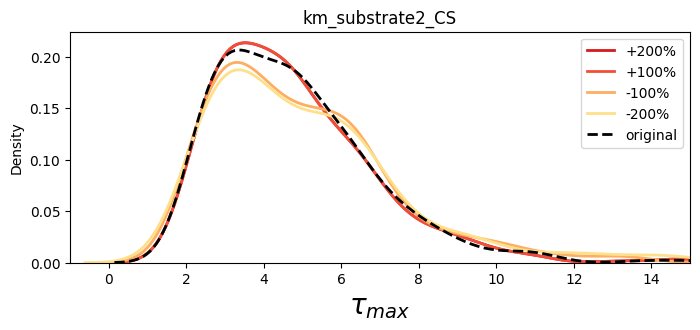

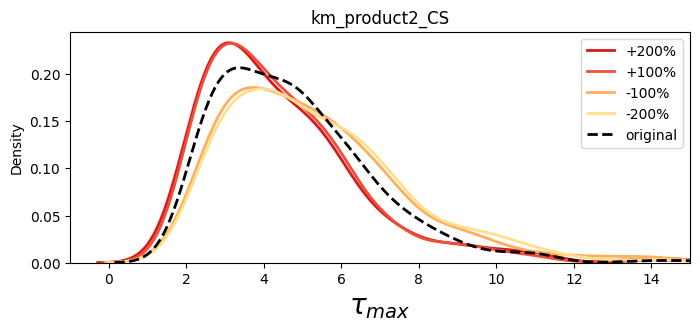

In [479]:
#______________PLOT EFFECTS OF GLOBAL PERTURBATION OF IMPORTANT ENZYMES_______________#
extensions = ['ddouble','double', 'half', 'hhalf']
r_colors = ['#D7191C','#F04E39','#FDAE61','#FEE08B']
labels = ['+200%','+100%','-100%','-200%']
for this_km_name in important_km_names:
    
    # Consolidate all eigenvalues from all steady states
    all_eigs = []
    for ss_idx in ss:
        og_max_eigs = pd.read_csv(f'analysis/{ss_idx}/sample_max_eig.csv').iloc[:,1].values
        valid_idx = np.where(og_max_eigs < -4)[0]
        og_max_eigs = og_max_eigs[valid_idx]
        all_eigs.extend(og_max_eigs)  # More efficient than appending in a loop

    # Consolidate all eigenvalues from global perturbation
    
    plt.figure(figsize=(8, 3))
    
    for ext, r_col, label in zip(extensions, r_colors, labels):
        all_perturbed_eigs = []
        for ss_idx in ss:
            max_eigs = pd.read_csv(f'analysis/global/{this_km_name}/sample_max_eig_{ss_idx}_{ext}.csv').iloc[:,1].values
            valid_idx = np.where(max_eigs < -4)[0]
            max_eigs = max_eigs[valid_idx]
            all_perturbed_eigs.extend(max_eigs)

        # Plot kernel density
        sns.kdeplot(-60/np.array(all_perturbed_eigs), color = r_col, fill=False, linewidth = 2, alpha=1, label= label)

    # Plot KDE for unperturbed
    sns.kdeplot(-60/np.array(all_eigs), color = 'k', linestyle = '--', linewidth = 2,  fill= False, alpha=1, label='original')
    plt.xlabel(r'$\tau_{max}$', fontsize = 20)
    plt.xlim([-1,15])
    plt.title(f'{this_km_name}')
    plt.legend()
    plt.savefig(f'figures/figure 4/global_{this_km_name}.svg', dpi=300, transparent=False, bbox_inches='tight')
    #plt.savefig(f'figures/figure 4/global_{this_km_name}.png', dpi=300, transparent=False, bbox_inches='tight')
    plt.show()
    plt.close()

# Diving deeper into 1 steady state 

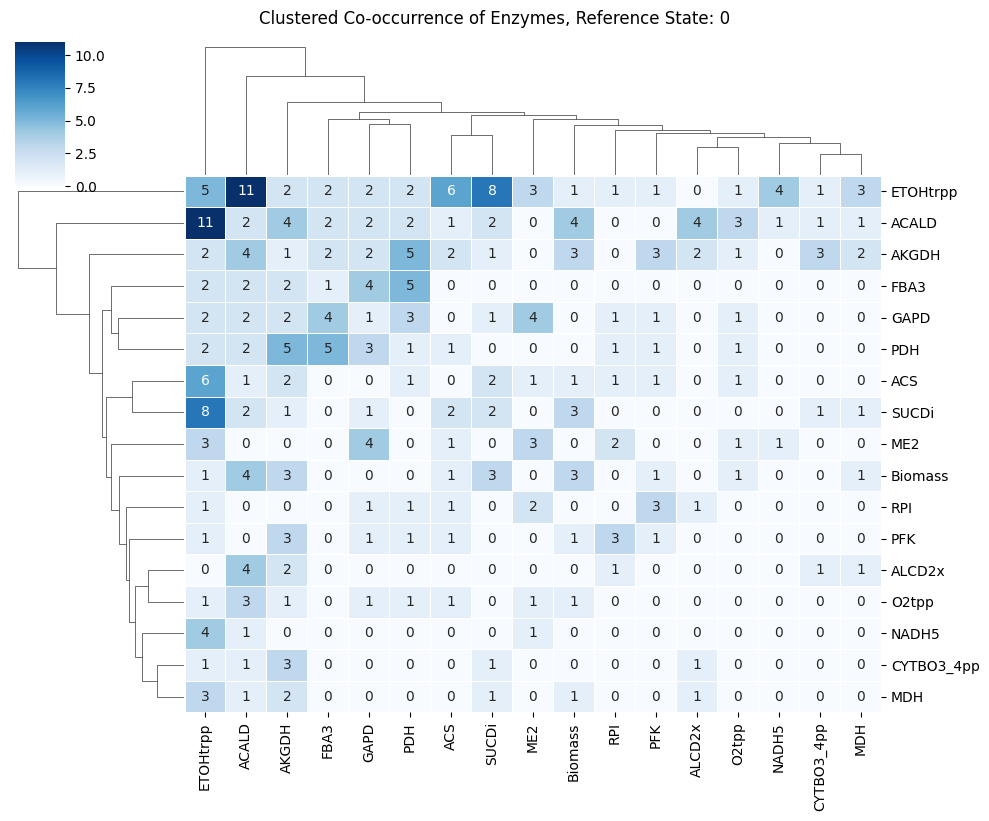

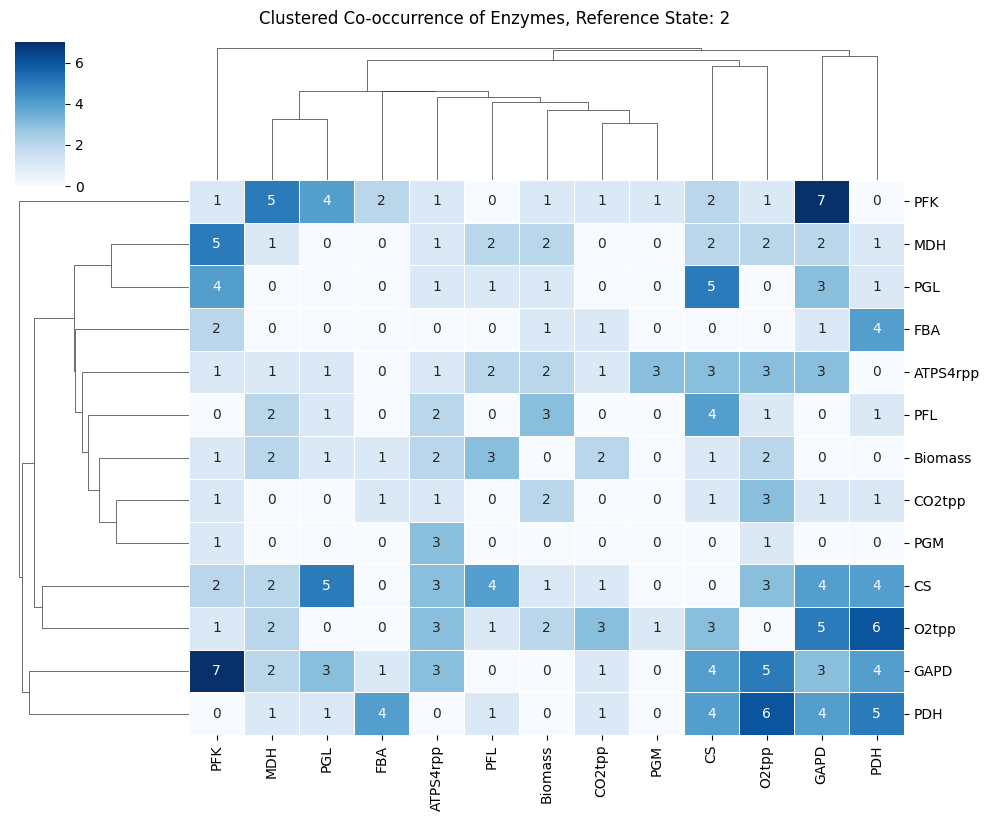

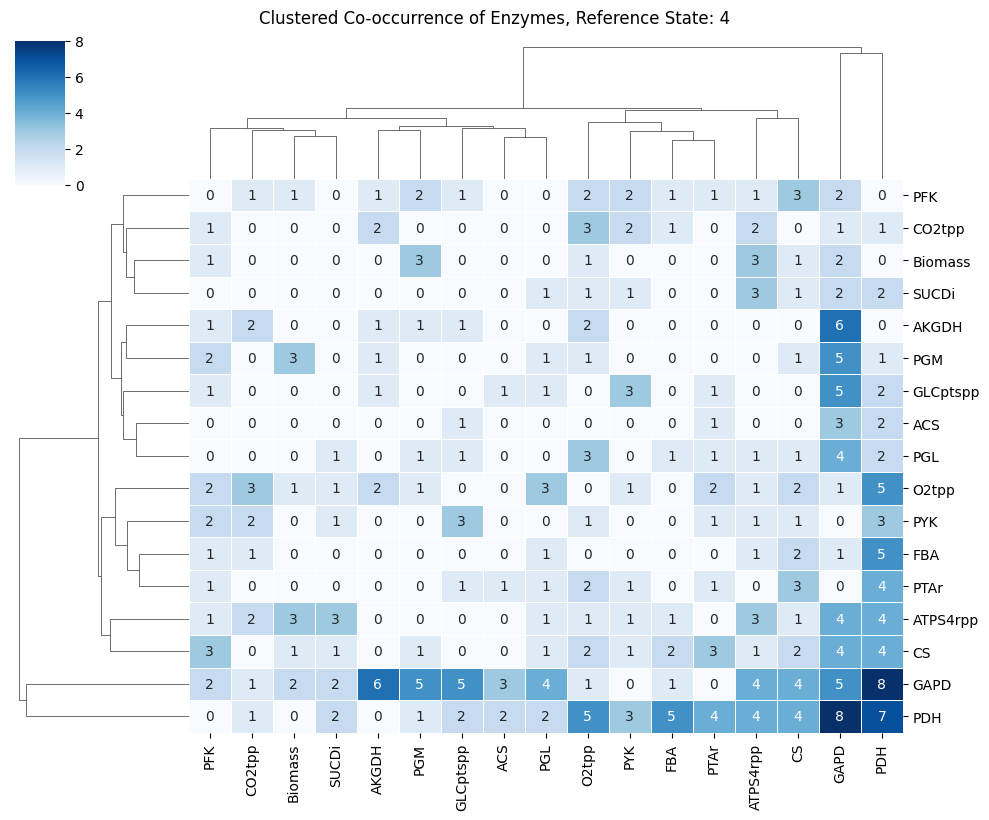

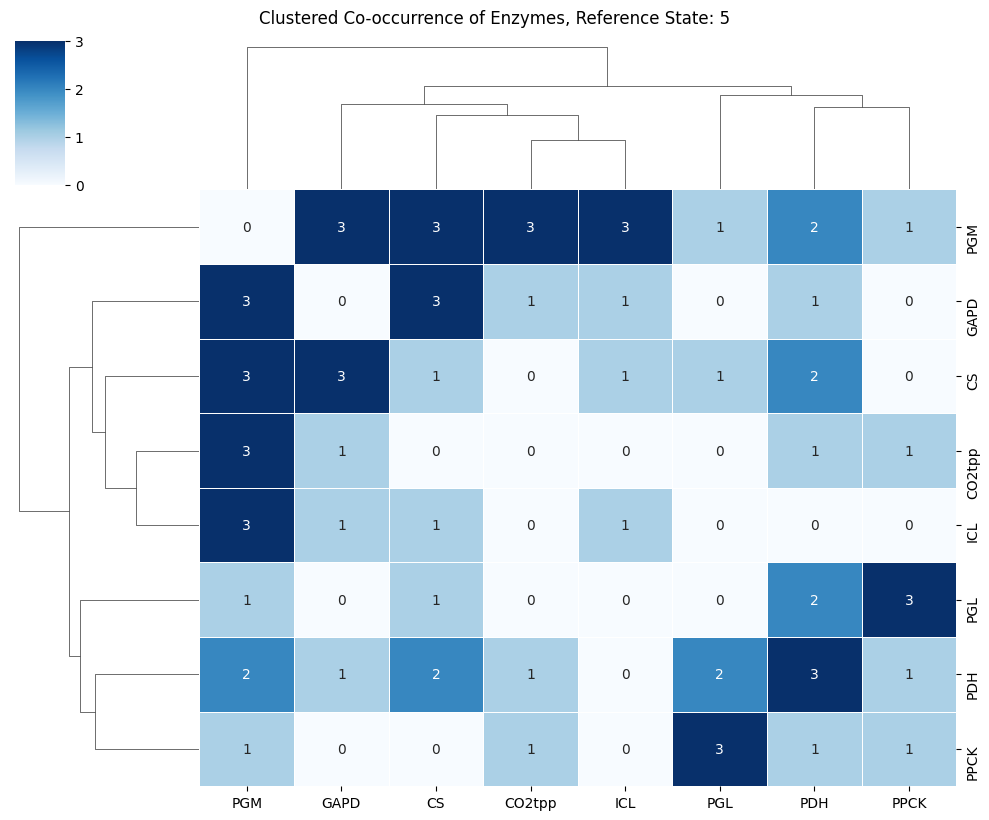

In [430]:
ss = [0, 2, 4, 5]
all_imp_rxns, all_tau_maxs = [], []
min_occurrences = 3  # Adjust this threshold as needed

for ss_idx in ss:

    og_max_eigs = pd.read_csv(f'analysis/{ss_idx}/sample_max_eig.csv').iloc[:, 1].values
    valid_no = len(np.where(og_max_eigs < 0)[0])
    km_data = pd.read_csv(f'analysis/{ss_idx}/important_kms_{n_top}.csv')
    all_tau_maxs.append(km_data['tau_max'].values)
    all_ixs = km_data.iloc[:, 0].values
    imp_rxns = []

    for this_ix in all_ixs:
        these_imp_kms = km_data.iloc[this_ix]['imp_kms']
        cleaned_string = these_imp_kms.strip("[]").replace("\n", "")
        elements_list = cleaned_string.split()
        these_imp_rxns = []
        
        for this_km in elements_list:
            _, _, rxn = this_km.split('_', 2)
            if 'LMPD' in rxn:
                these_imp_rxns.append('Biomass')
            else:
                these_imp_rxns.append(rxn[:-1])
        
        imp_rxns.append(these_imp_rxns[::-1])

    all_imp_rxns.append(imp_rxns)

    # Count occurrences of each pair
    pair_counts = Counter()
    for sublist in imp_rxns:
        for pair in combinations(sorted(sublist), 2):
            pair_counts[pair] += 1

    # Find words that have at least one co-occurrence > min_occurrences
    valid_words = set()
    for (word1, word2), count in pair_counts.items():
        if count >= min_occurrences:
            valid_words.update([word1, word2])

    # Filter out pairs that involve words not in valid_words
    filtered_pair_counts = {pair: count for pair, count in pair_counts.items() if pair[0] in valid_words and pair[1] in valid_words}

    # Create a co-occurrence matrix for valid words only
    labels = sorted(valid_words)
    matrix = pd.DataFrame(0, index=labels, columns=labels)

    # Fill the matrix with pair counts
    for (item1, item2), count in filtered_pair_counts.items():
        matrix.loc[item1, item2] = count
        matrix.loc[item2, item1] = count  # Ensure symmetry

    # Plot clustered heatmap with dendrograms
    sns.clustermap(matrix, cmap="Blues", annot=True, fmt="d", linewidths=0.5, figsize=(10, 8))
    plt.suptitle(f"Clustered Co-occurrence of Enzymes, Reference State: {ss_idx}", y=1.02)
    plt.savefig(f'figures/figure 4/local_{ss_idx}.svg', dpi=300, transparent=False, bbox_inches='tight')
    plt.savefig(f'figures/figure 4/local_{ss_idx}.png', dpi=300, transparent=False, bbox_inches='tight')
    plt.show()
    plt.close()

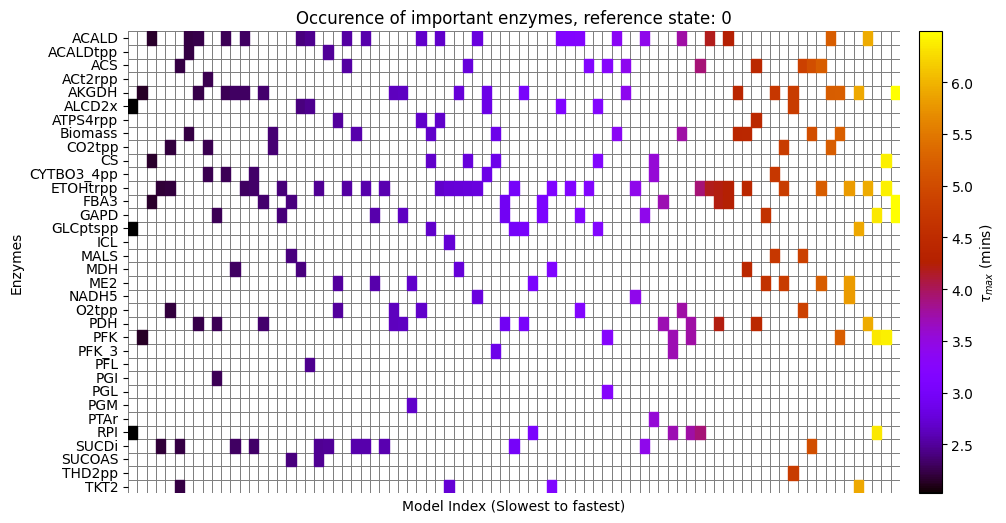

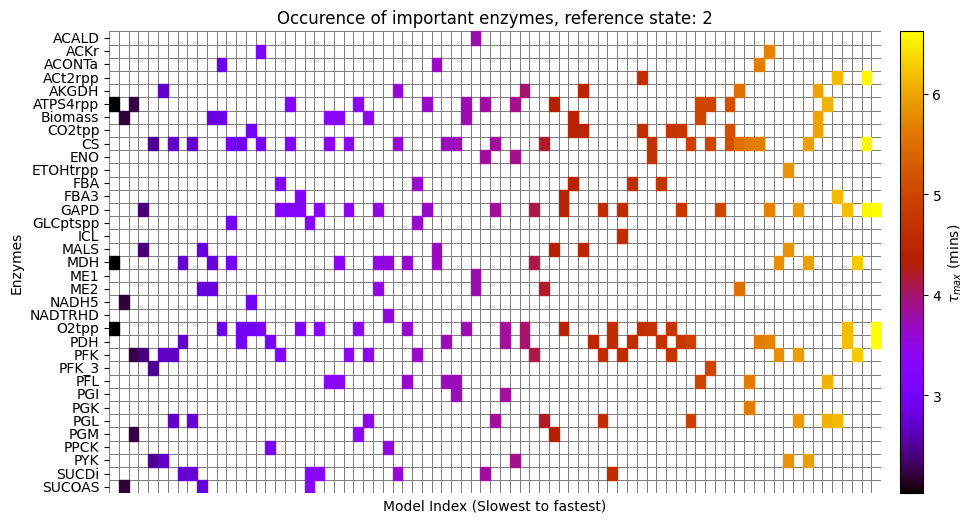

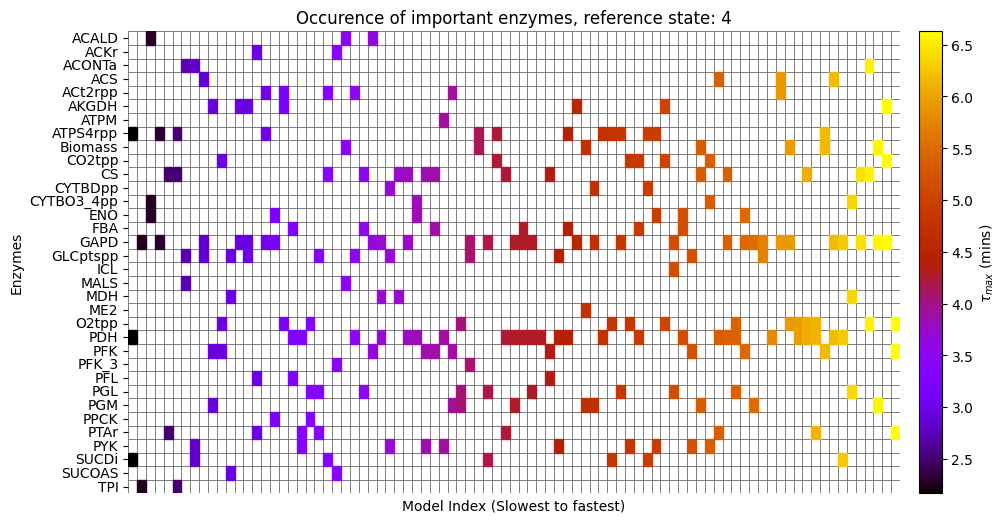

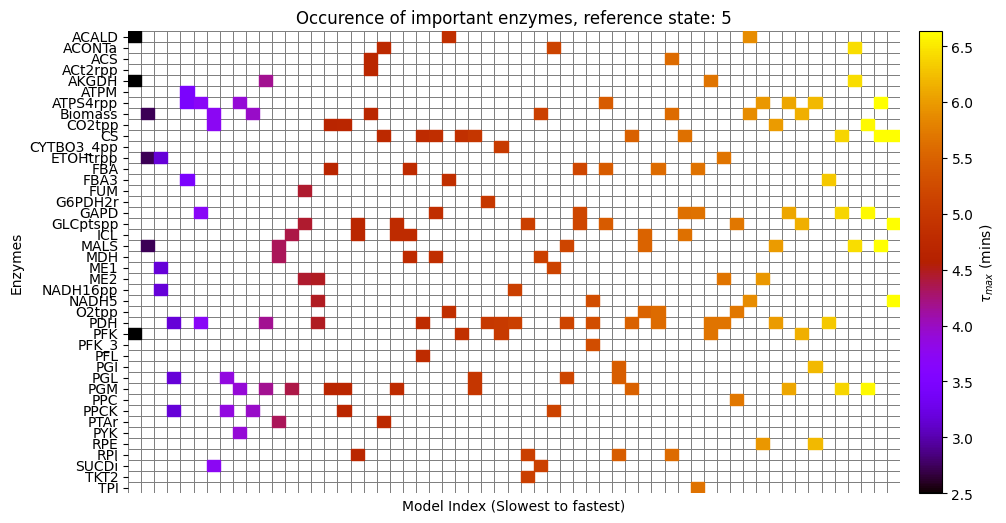

In [431]:
for this_imp_rxns, tau_max, ss_idx in zip(all_imp_rxns, all_tau_maxs, ss):

    data = this_imp_rxns
    # Get a sorted list of unique strings (y-axis labels)
    unique_strings = sorted(set(word for sublist in data for word in sublist))
    
    # Create a binary presence matrix (rows = unique strings, cols = sublist indices)
    presence_matrix = pd.DataFrame(0, index=unique_strings, columns=range(len(data)))
    
    # Fill the matrix (1 if string is present in the sublist, 0 otherwise)
    for col_idx, sublist in enumerate(data):
        for word in sublist:
            presence_matrix.loc[word, col_idx] = 1
    
    # Normalize tau_max values between 0 and 1 for colormap mapping
    norm_tau = (np.array(tau_max) - min(tau_max)) / (max(tau_max) - min(tau_max) + 1e-9)
    
    # Define colormap
    cmap = sns.color_palette('gnuplot', as_cmap=True)
    norm = mcolors.Normalize(vmin=min(tau_max), vmax=max(tau_max))  # Normalize tau_max range
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)  # Colorbar object
    
    # Create a colored matrix where 1s are mapped to their column color
    colored_matrix = np.zeros((*presence_matrix.shape, 4))  # Shape (rows, cols, RGBA)
    
    for col_idx in range(len(data)):
        for row_idx in range(len(unique_strings)):
            if presence_matrix.iloc[row_idx, col_idx] == 1:
                colored_matrix[row_idx, col_idx] = cmap(norm(tau_max[col_idx]))  # Assign color
    
    # Plot the heatmap
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.heatmap(
        presence_matrix,
        annot=False,
        cmap="gray",  # Base colormap (unused since we color manually)
        cbar=False,  # Hide default colorbar
        linewidths=0.5,
        linecolor='gray',
        xticklabels=False,  # Hide x-axis labels (optional)
        yticklabels=True,
        mask=presence_matrix == 0  # Hide zeros
    )
    
    # Overlay the colored patches
    for i in range(presence_matrix.shape[0]):  # Rows
        for j in range(presence_matrix.shape[1]):  # Columns
            if presence_matrix.iloc[i, j] == 1:
                rect = plt.Rectangle((j, i), 1, 1, color=tuple(colored_matrix[i, j]), transform=ax.transData)
                ax.add_patch(rect)
    
    # Add colorbar
    cbar = fig.colorbar(sm, ax=ax, orientation="vertical", pad=0.02)
    cbar.set_label(r"$\tau_{max}$ (mins)")
    
    # Axis labels
    plt.xlabel("Model Index (Slowest to fastest)")
    plt.ylabel("Enzymes")
    plt.title(f"Occurence of important enzymes, reference state: {ss_idx}")
    plt.savefig(f'figures/figure 4/local_enzyme_heatmap_{ss_idx}.svg', dpi=300, transparent=False, bbox_inches='tight')
    plt.savefig(f'figures/figure 4/local_enzyme_heatmap_{ss_idx}.png', dpi=300, transparent=False, bbox_inches='tight')
    plt.show()
    plt.close()

## Check relation of important co-occuring enzyme paris with $\lambda_{max}$

In [340]:
ss = [0, 2, 4, 5]
all_imp_rxns, all_tau_maxs = [], []
min_occurrences = 3  # Adjust this threshold as needed
top_enzymes = pd.read_csv(f'analysis/global/top_enzymes.csv').iloc[:,1].values

for ss_idx in ss:

    og_max_eigs = pd.read_csv(f'analysis/{ss_idx}/sample_max_eig.csv').iloc[:, 1].values
    ixs = pd.read_csv(f'analysis/{ss_idx}/ixs.csv').iloc[:, 1].values
    
    km_data = pd.read_csv(f'analysis/{ss_idx}/important_kms_{n_top}.csv')
    
    all_tau_maxs.append(km_data['tau_max'].values)
    all_ixs = km_data.iloc[:, 0].values
    imp_rxns = []

    for this_ix in range(len(ixs)):
        these_imp_kms = km_data.iloc[this_ix]['imp_kms']
        cleaned_string = these_imp_kms.strip("[]").replace("\n", "")
        elements_list = cleaned_string.split()
        these_imp_rxns = []
        
        for this_km in elements_list:
            _, _, rxn = this_km.split('_', 2)
            if 'LMPD' in rxn:
                these_imp_rxns.append('Biomass')
            else:
                these_imp_rxns.append(rxn[:-1])
        
        imp_rxns.append(these_imp_rxns[::-1])
    
    # Generate all unique pairs from n_strings
    pairs = set(combinations(top_enzymes, 2))
    
    # Dictionary to store where each pair appears
    pair_occurrences = {pair: [] for pair in pairs}
    
    # Iterate through each sublist and record pair occurrences
    for i, sublist in enumerate(imp_rxns):
        for pair in pairs:
            if pair[0] in sublist and pair[1] in sublist:
                pair_occurrences[pair].append(km_data['tau_max'].values[i])

    file_path = f"analysis/global/pair_occurrences_{ss_idx}.json"

    # Convert tuple keys to strings
    pair_occurrences_str_keys = {str(pair): occurrences for pair, occurrences in pair_occurrences.items()}
    
    # Save dictionary as JSON
    with open(file_path, "w") as f:
        json.dump(pair_occurrences_str_keys, f, indent=4)

file_path = f"analysis/global/top_enzyme_pairs.json"
with open(file_path, "w") as f:
    json.dump(list(pair_occurrences.keys()), f, indent=4)


In [377]:
file_path = f"analysis/global/top_enzyme_pairs.json"
with open(file_path, "r") as f:
    all_pairs = json.load(f)

co_occurence_data = pd.DataFrame(columns = ['enzyme pair', 'occurrence', 'dynamics'])
for ix,this_pair in enumerate(all_pairs):
    
    this_pair_ss_oc = []  # store number of occurences for each pair
    this_pair_tau_max = [] # store tau maxes for each pair
    for ss_idx in ss:
        # Load JSON file
        file_path = f"analysis/global/pair_occurrences_{ss_idx}.json"
        with open(file_path, "r") as f:
            loaded_data = json.load(f)
        
        # Convert string keys back to tuples
        pair_occurrences = {eval(key): value for key, value in loaded_data.items()}

        #get occurences for each steady state
        this_pair_ss_oc.append(len(pair_occurrences[tuple(this_pair)]))

        #store all the tau maxs
        for this_tau_max in pair_occurrences[tuple(this_pair)]:
            this_pair_tau_max.append(this_tau_max)

    co_occurence_data.loc[ix] = [this_pair, this_pair_ss_oc, this_pair_tau_max]
    
co_occurence_data.to_csv(f'analysis/global/pair_occurrence_dynamics_data.csv')

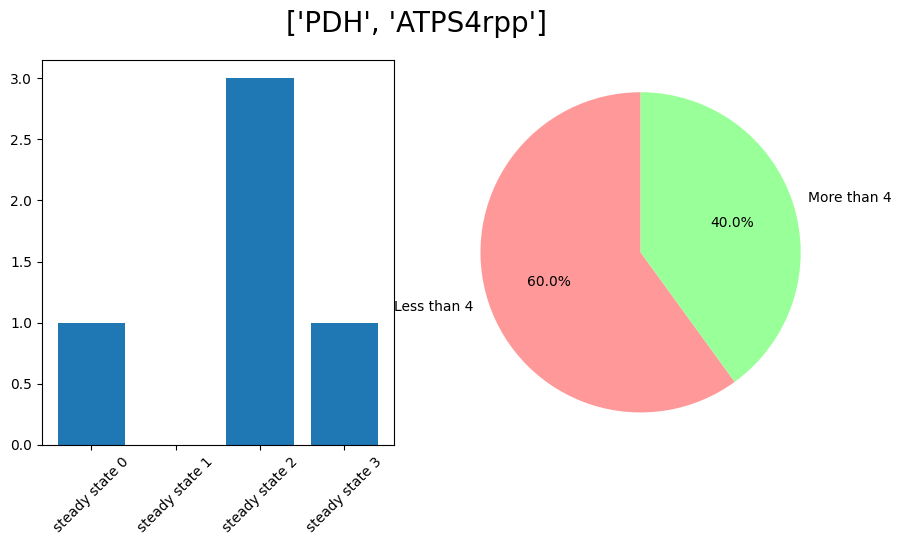

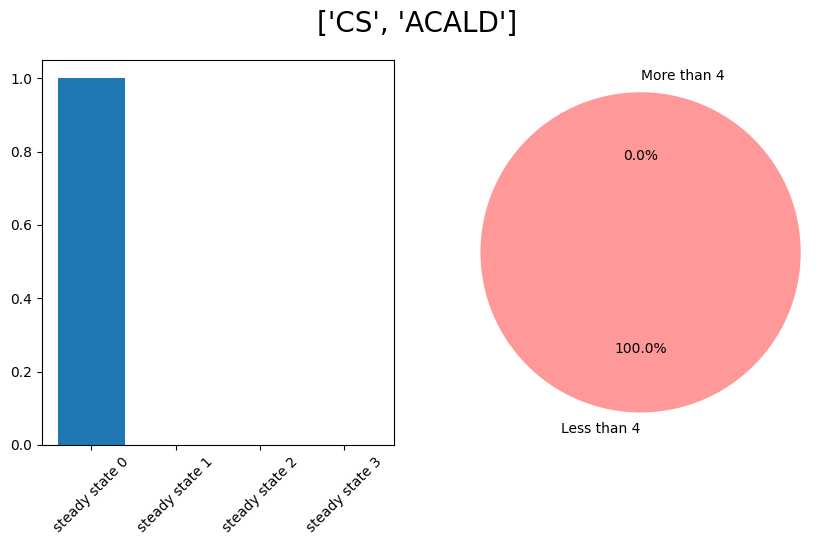

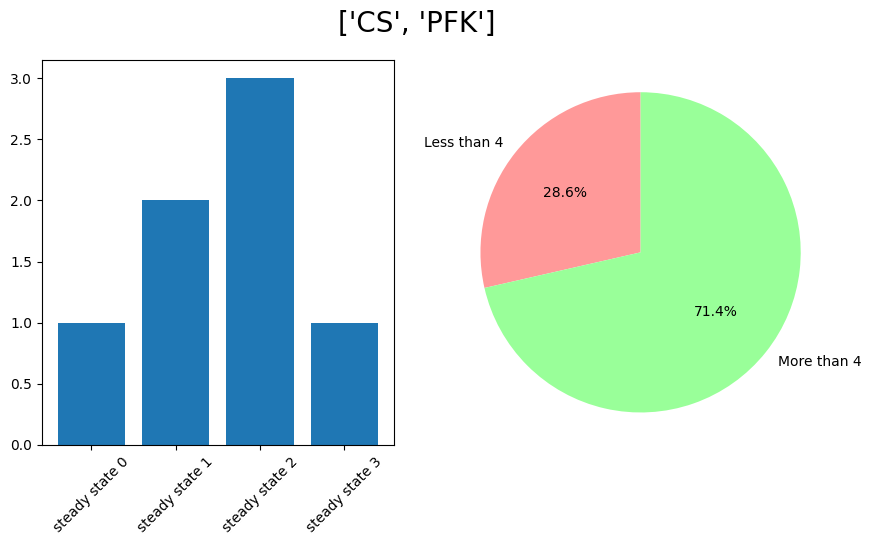

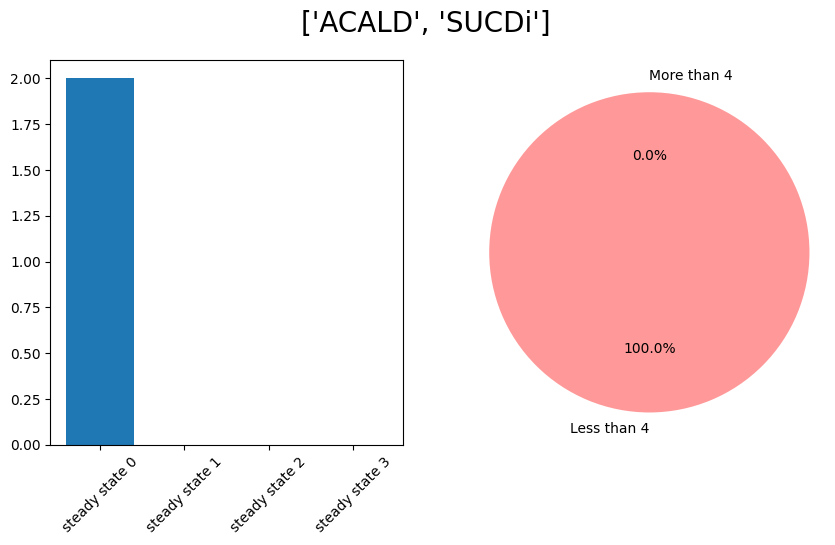

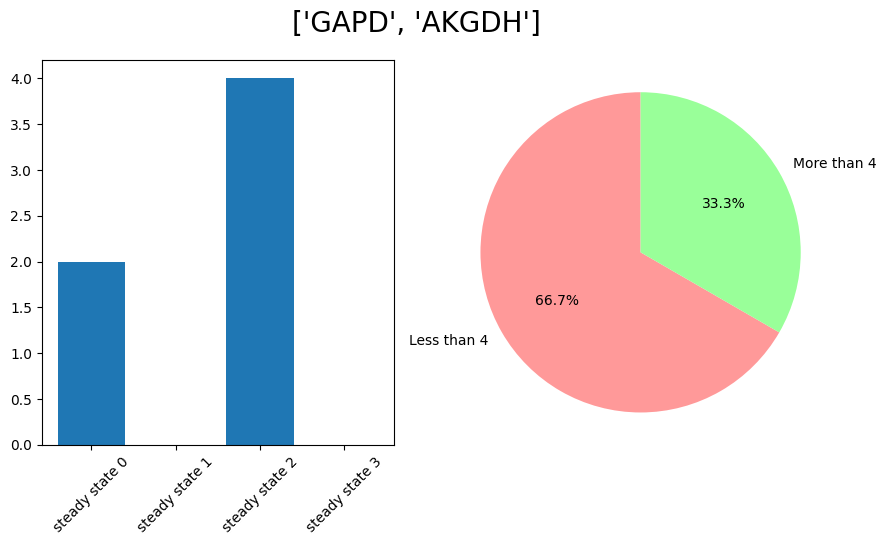

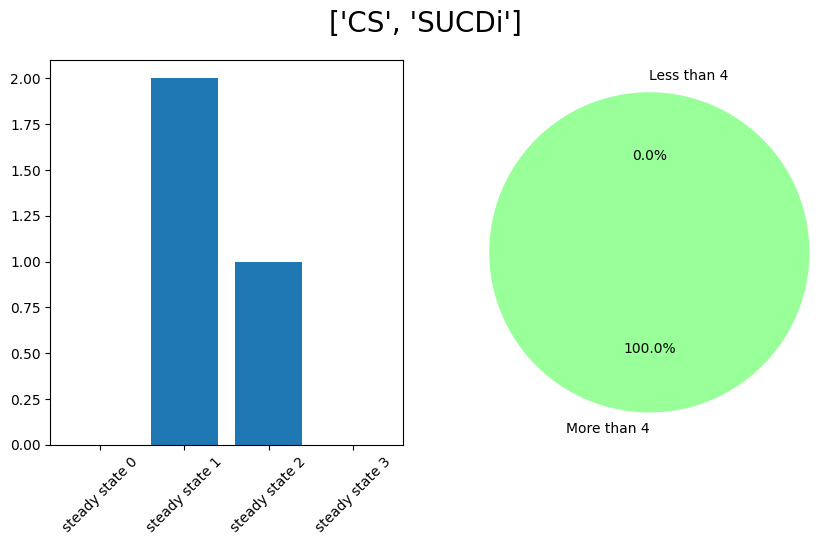

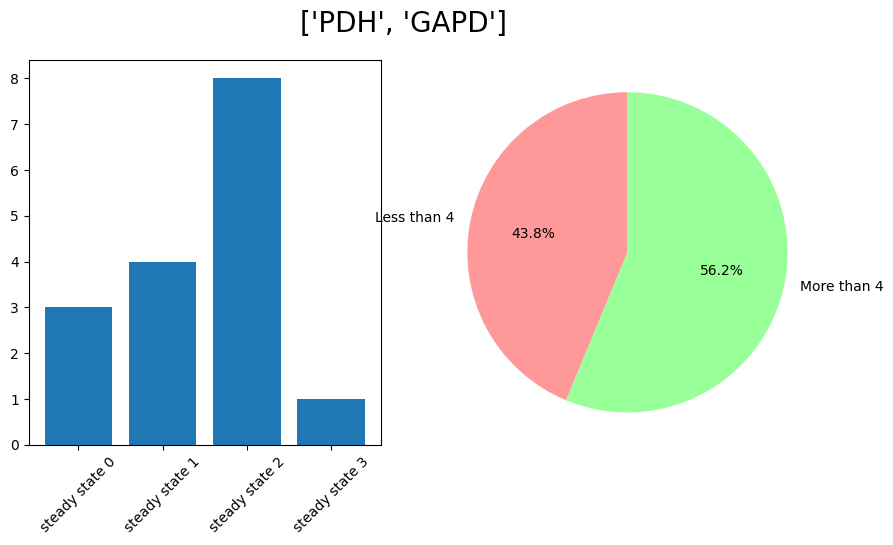

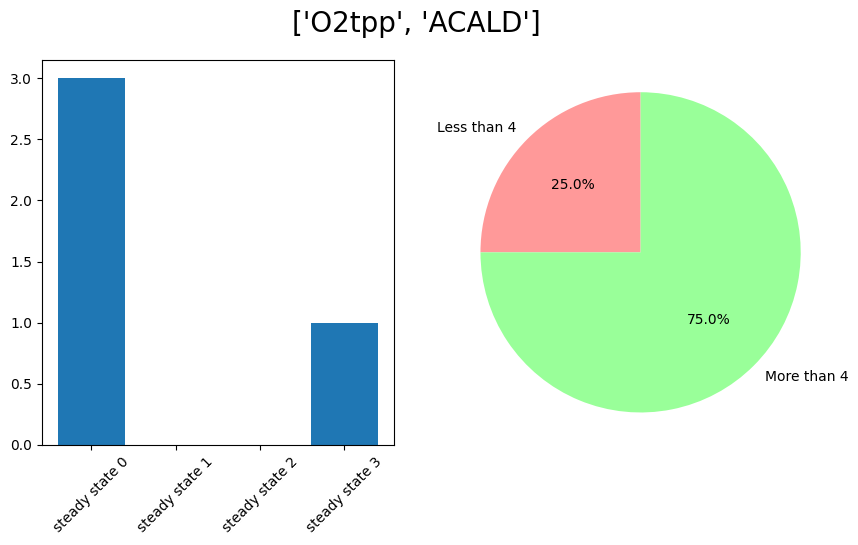

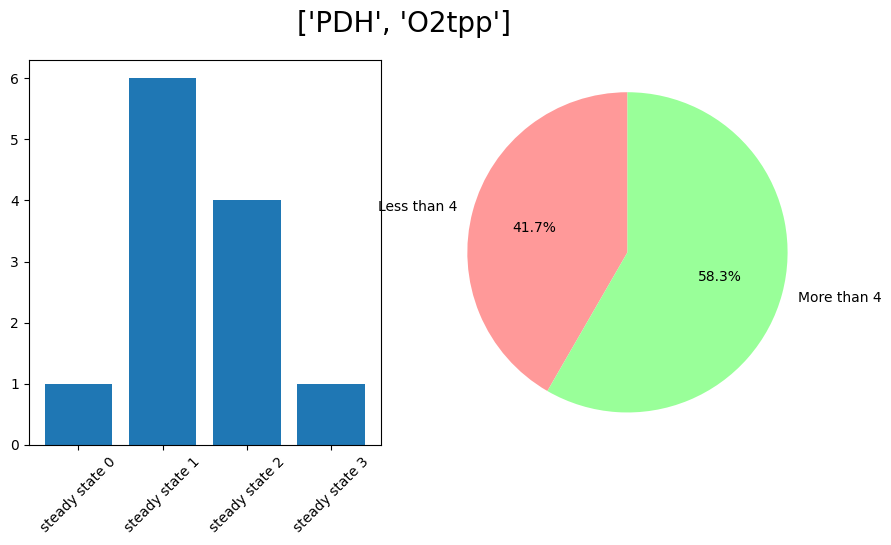

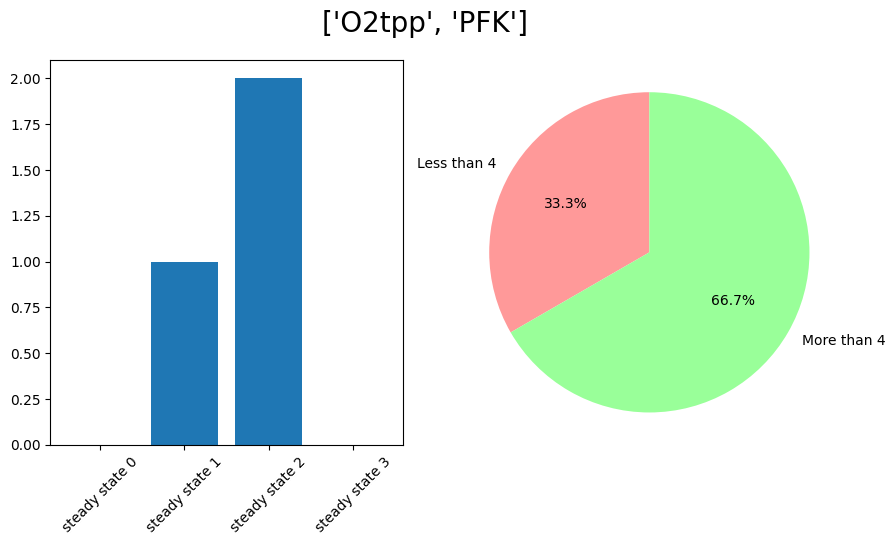

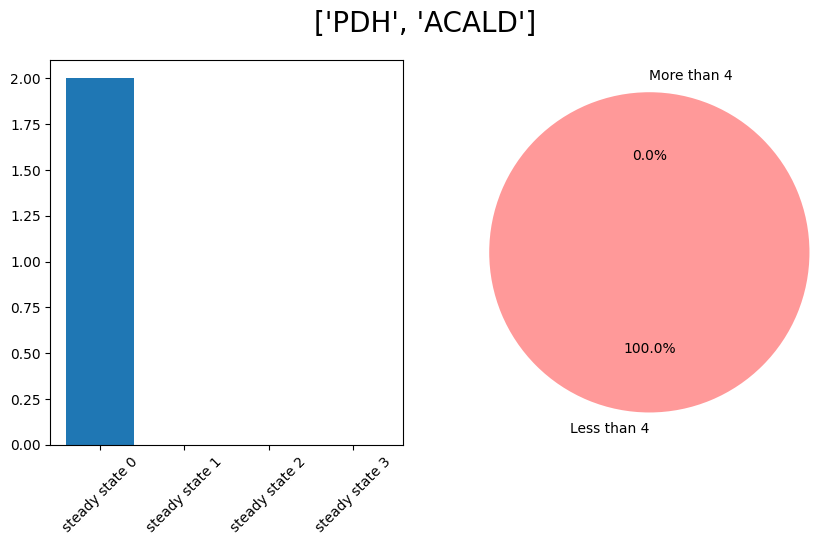

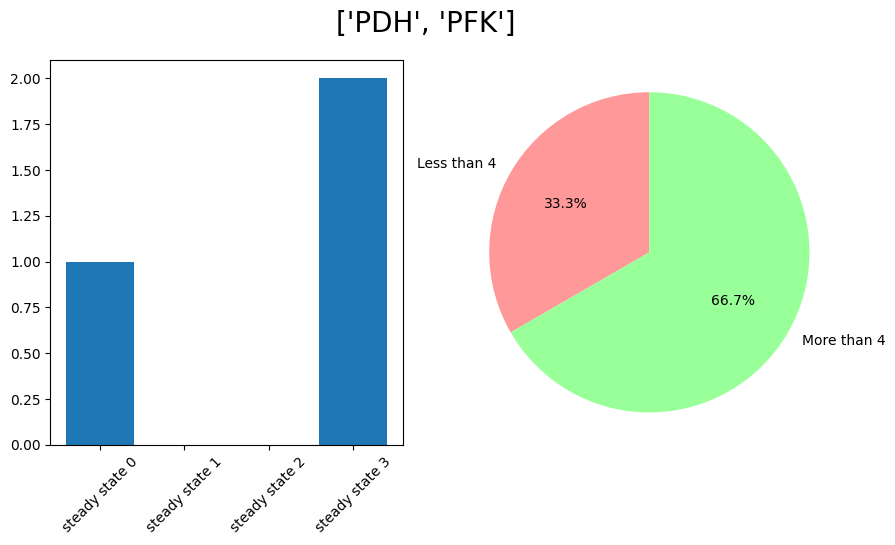

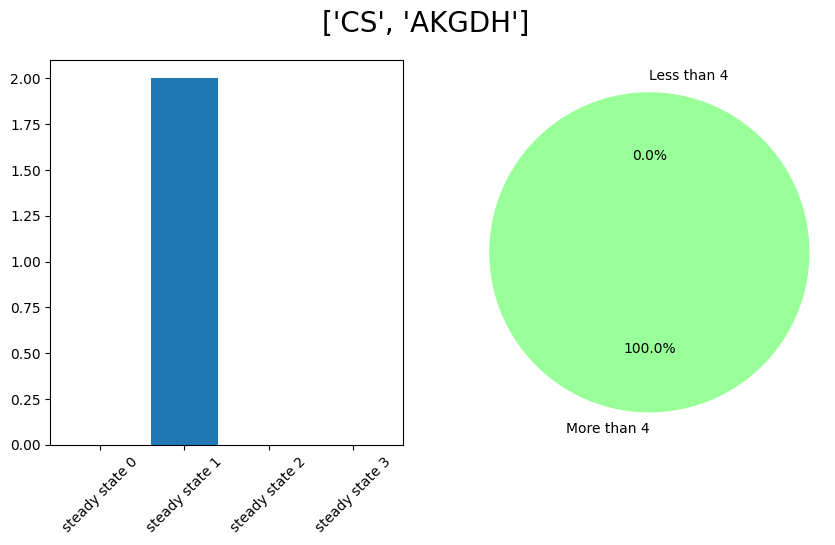

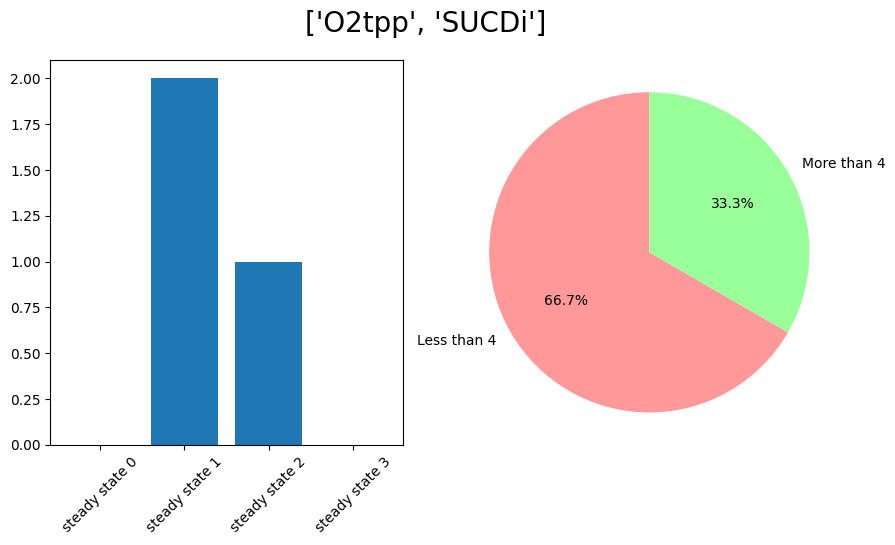

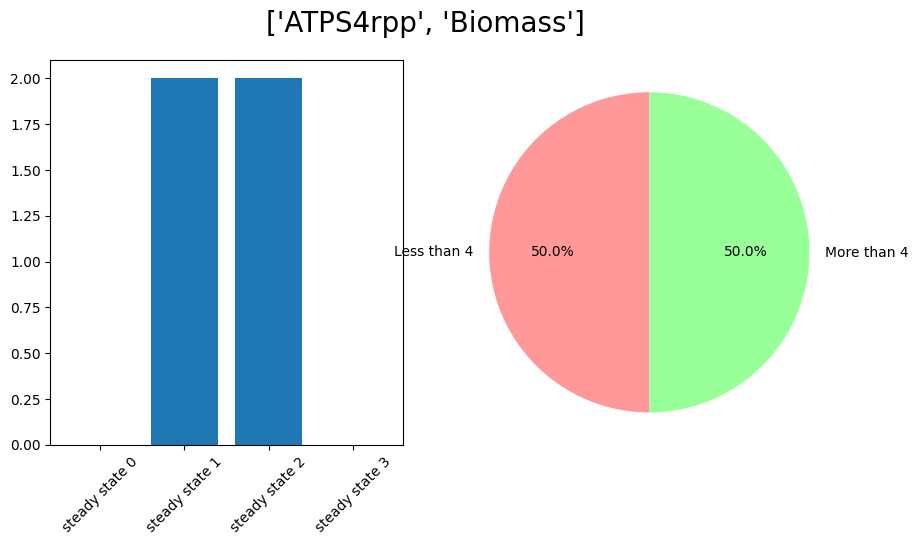

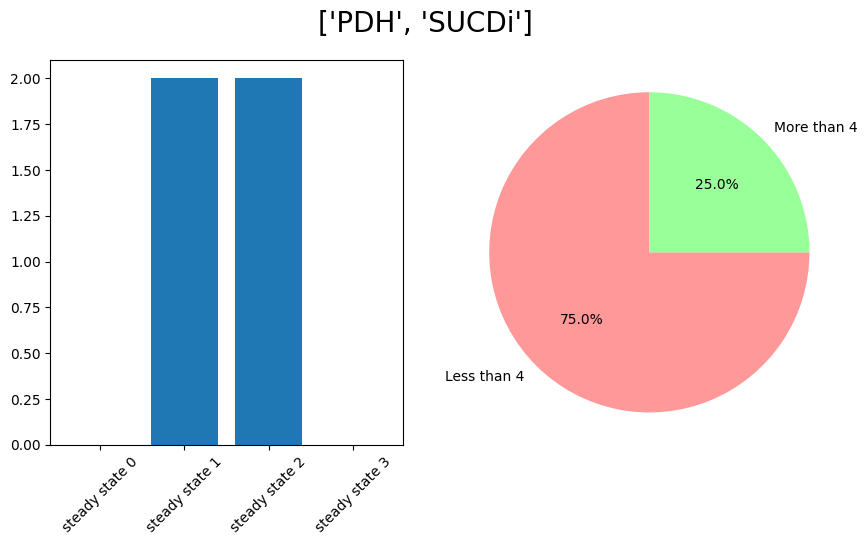

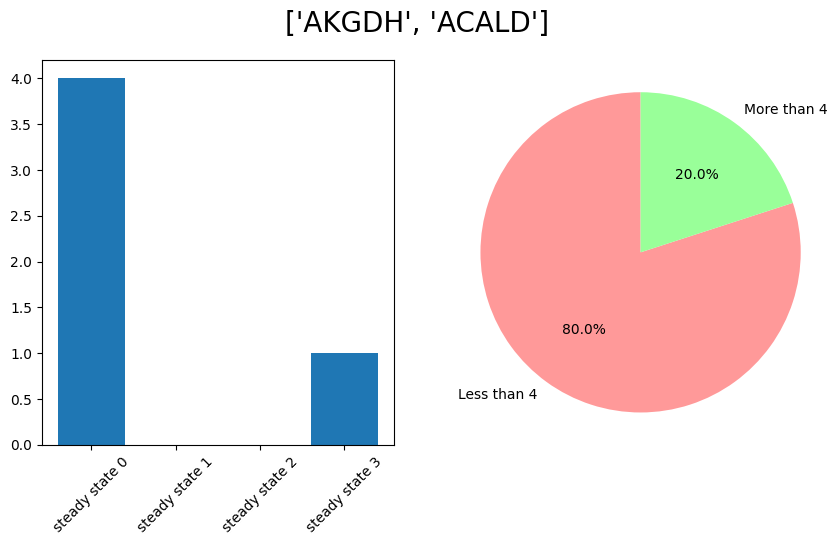

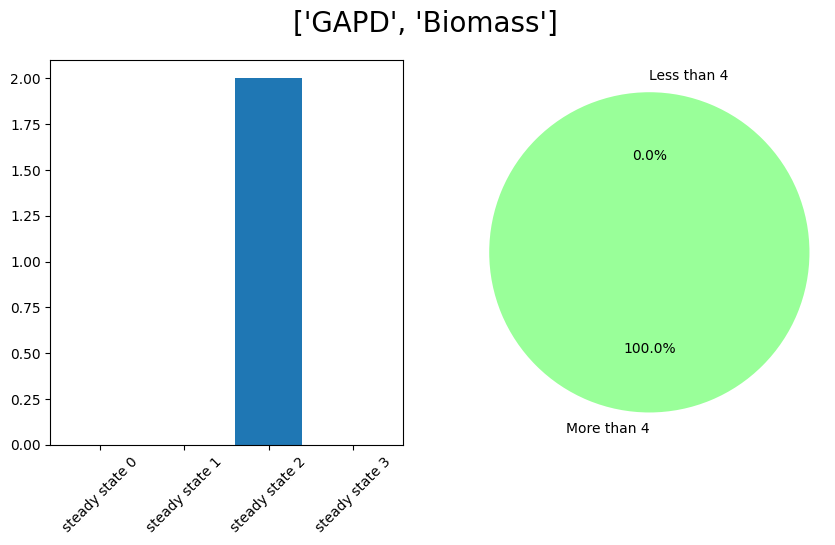

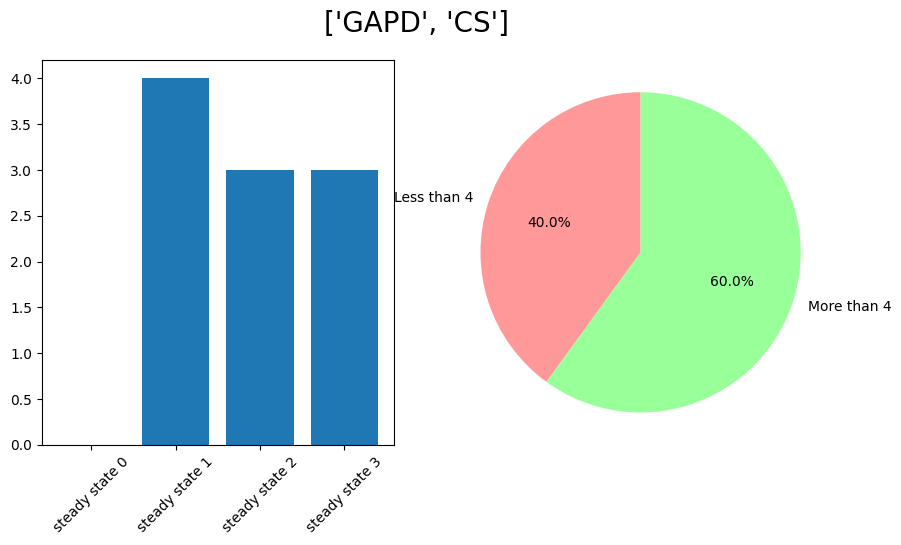

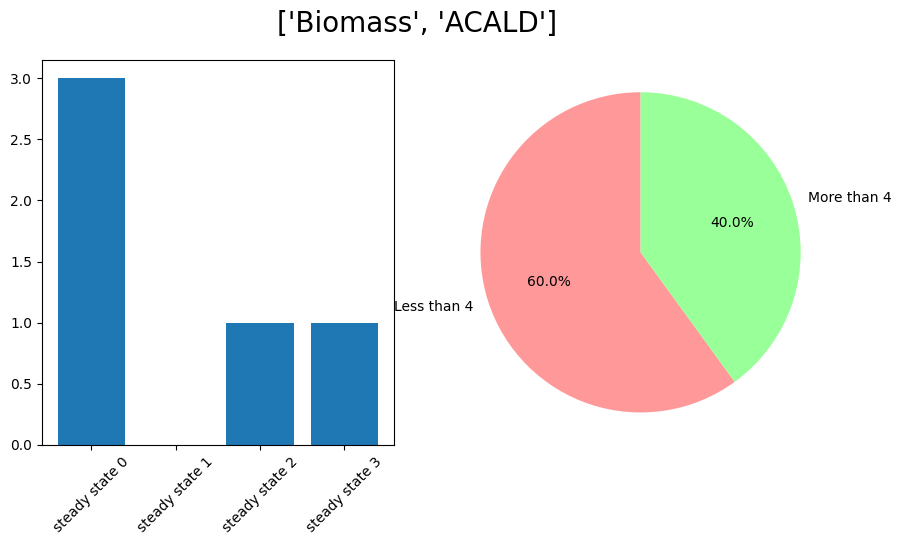

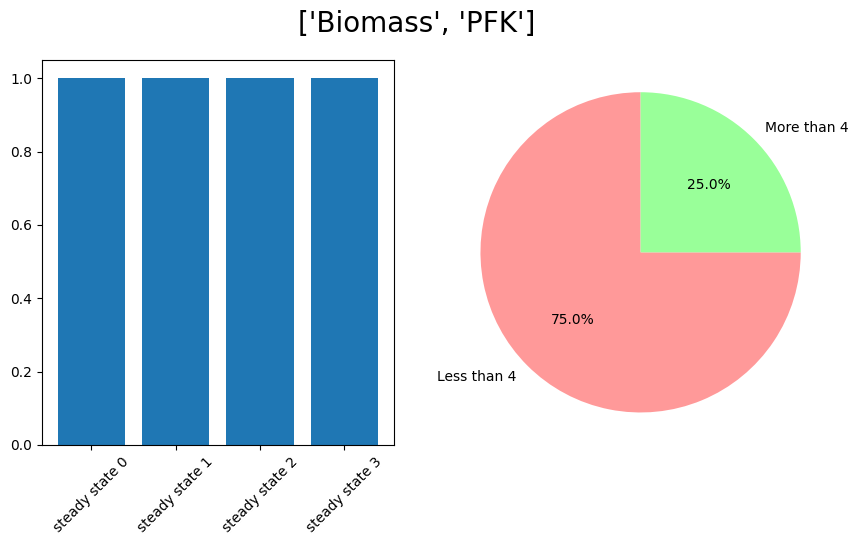

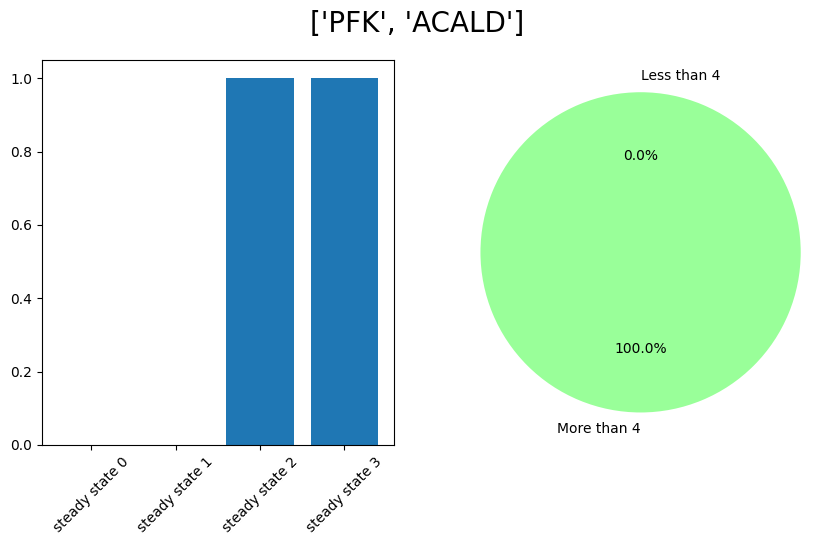

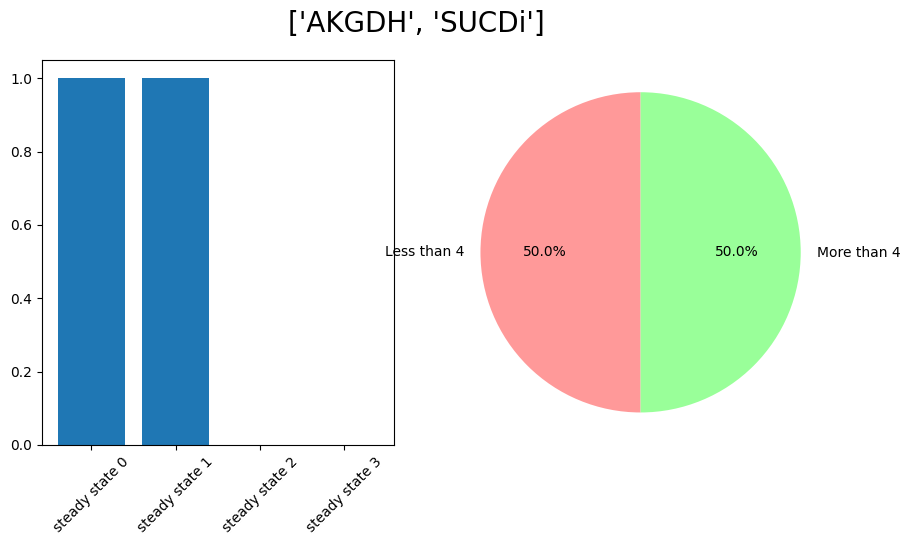

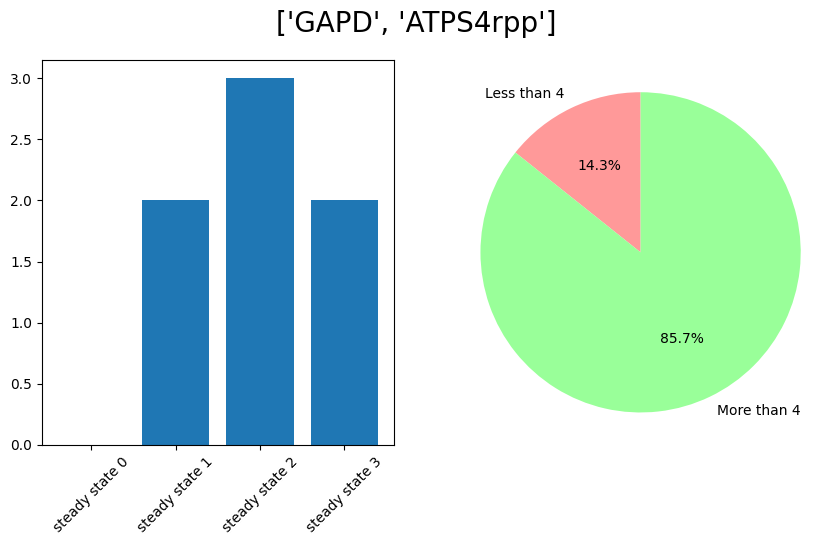

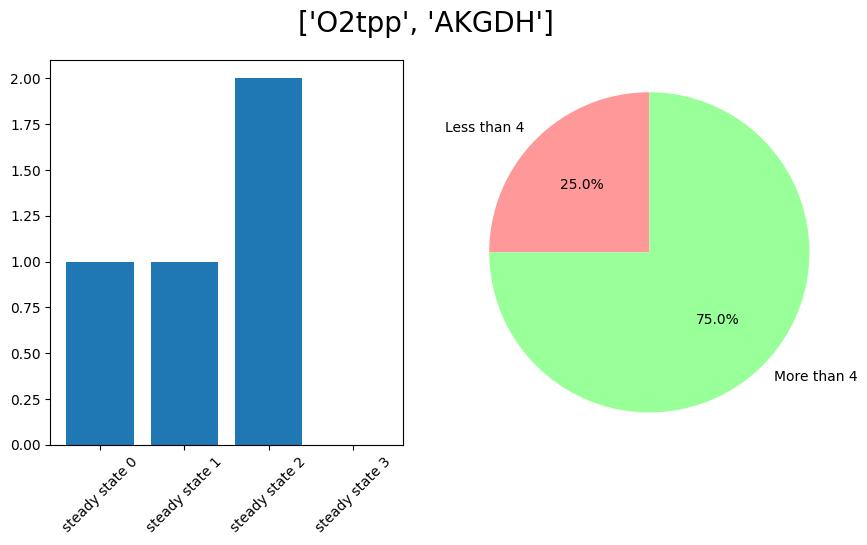

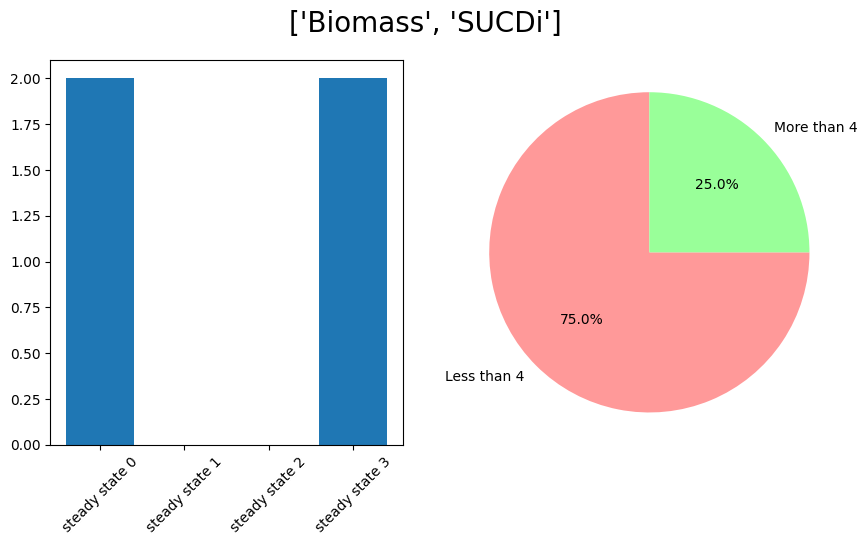

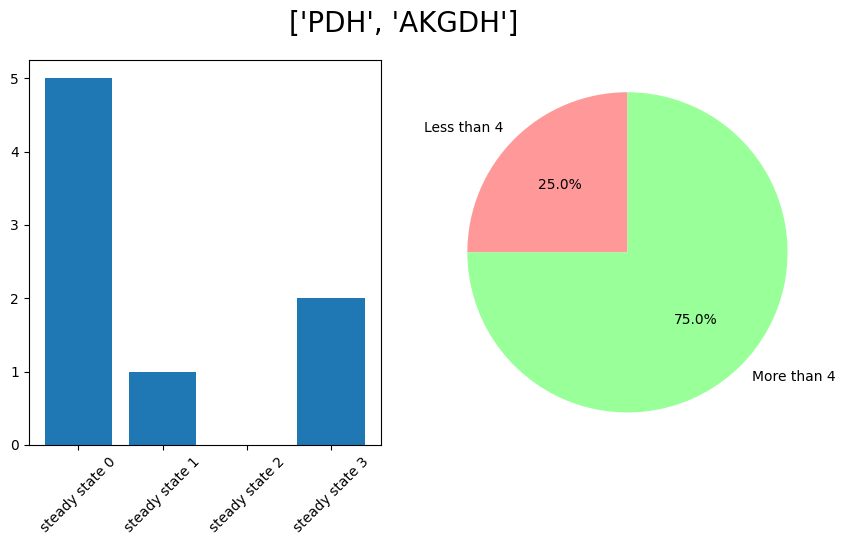

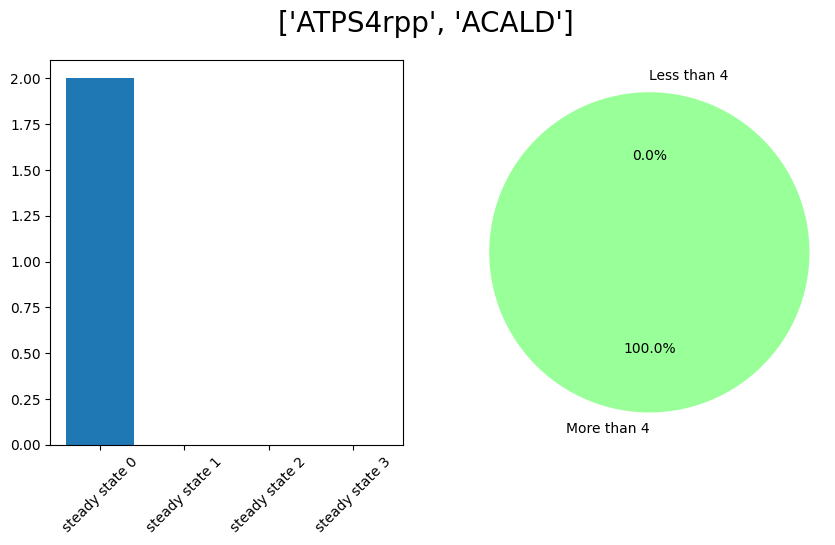

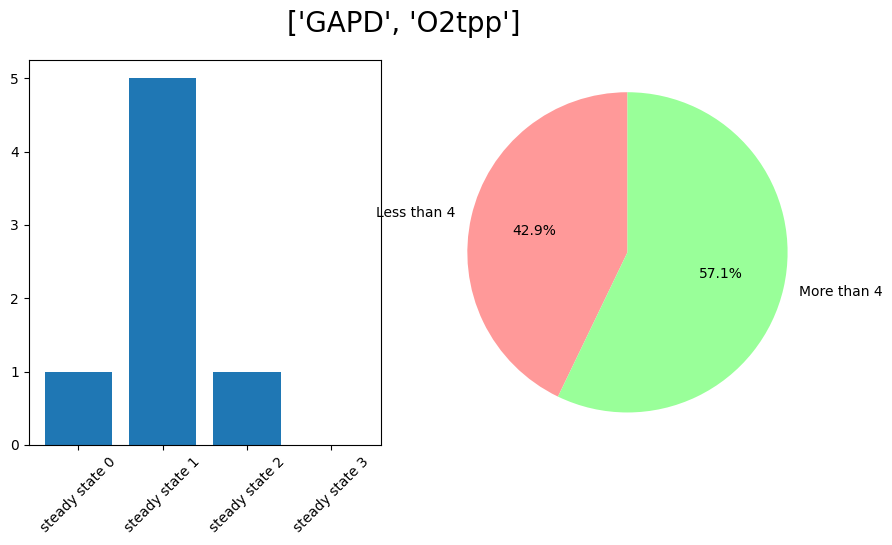

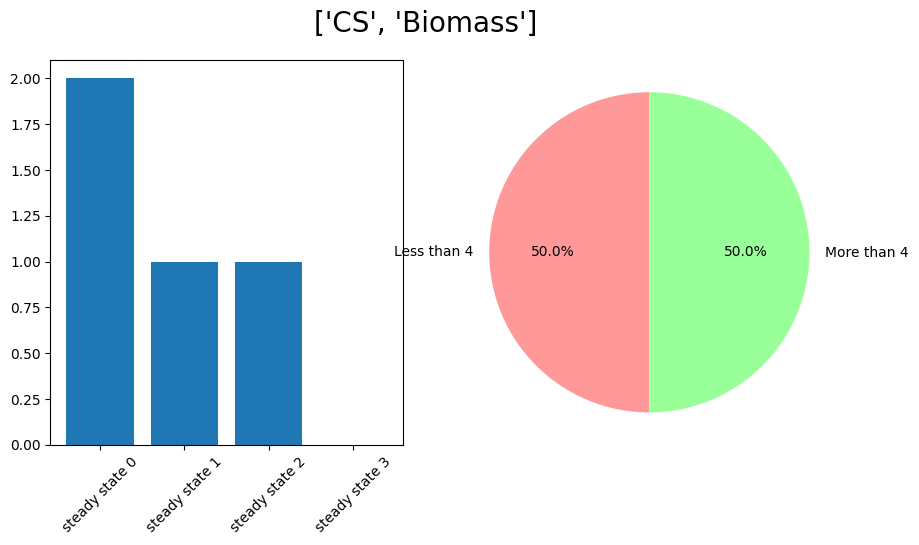

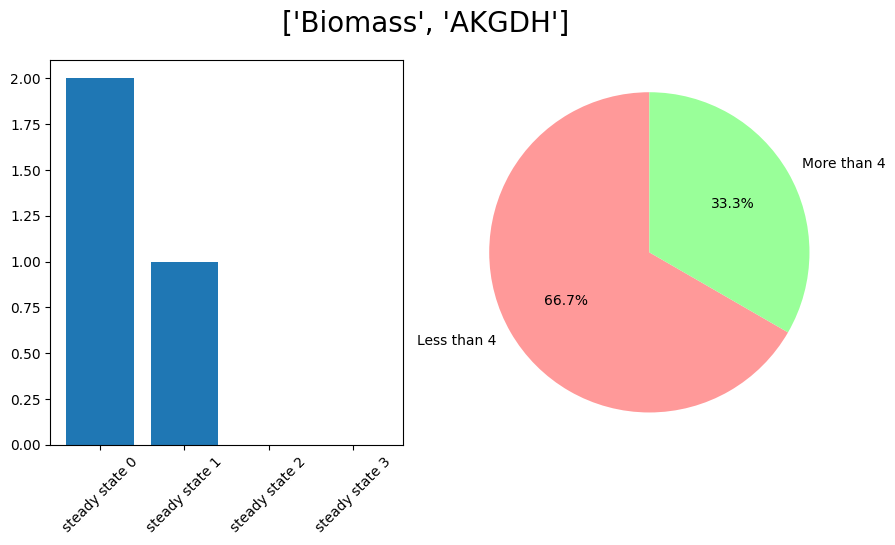

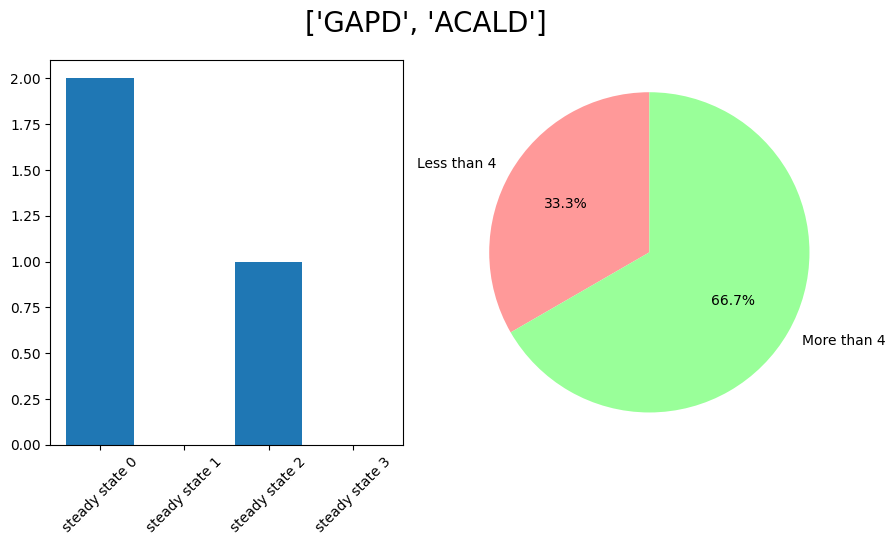

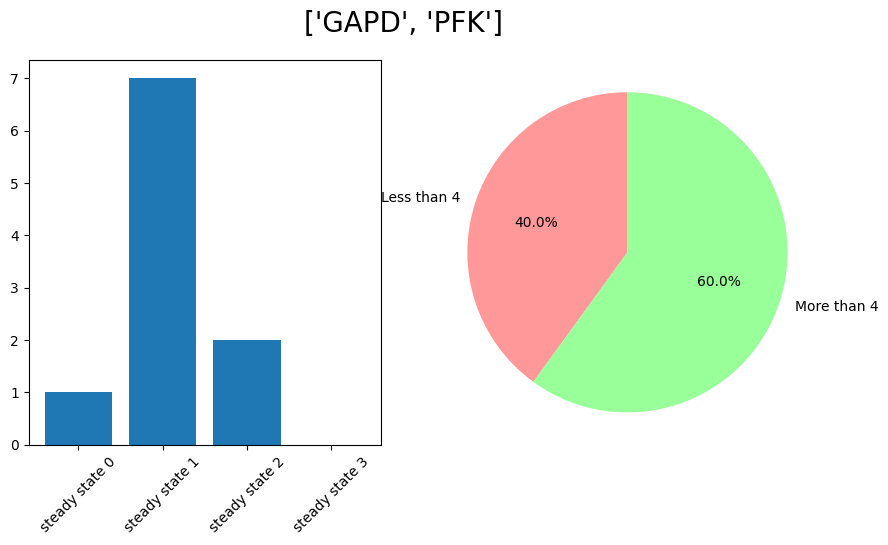

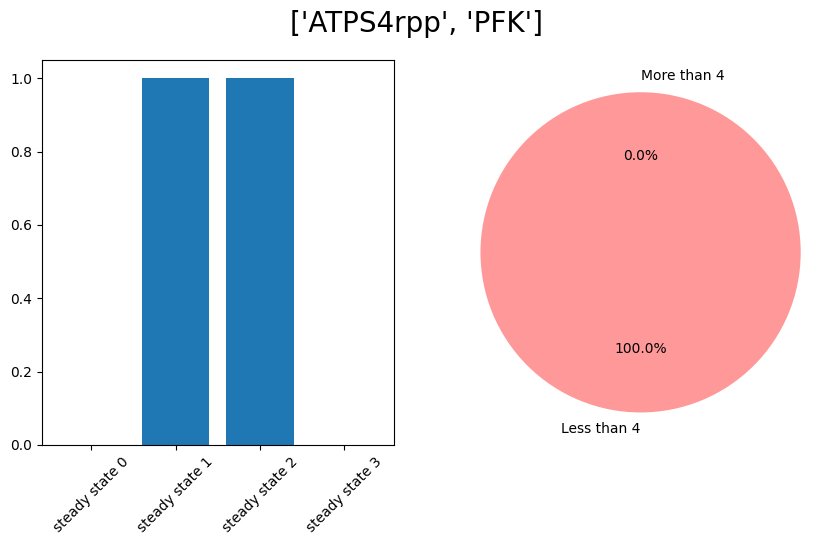

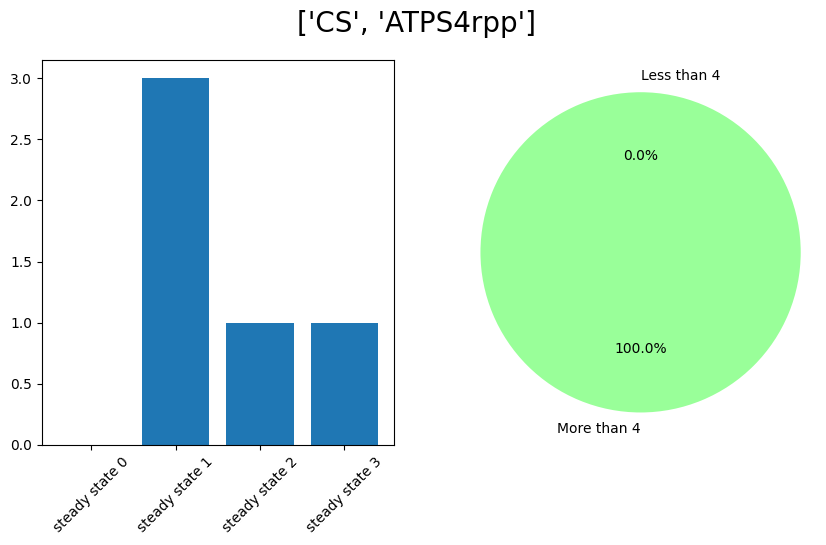

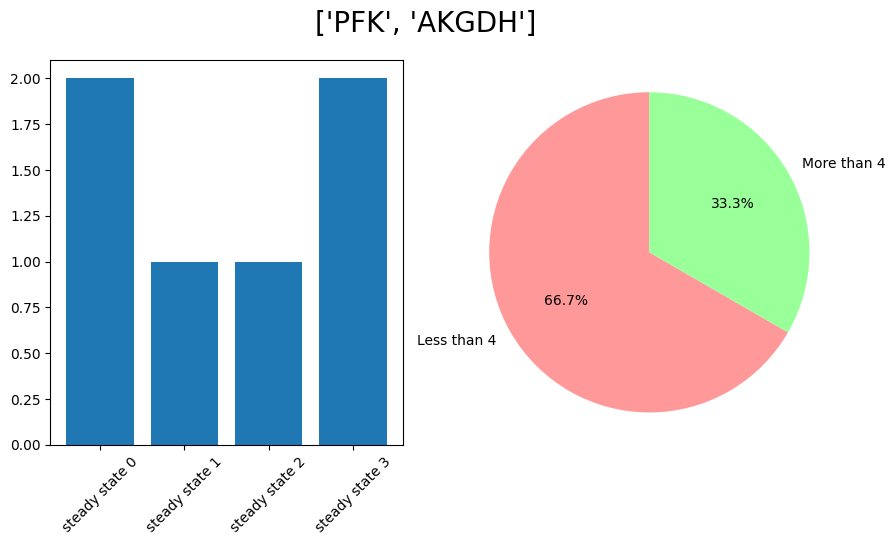

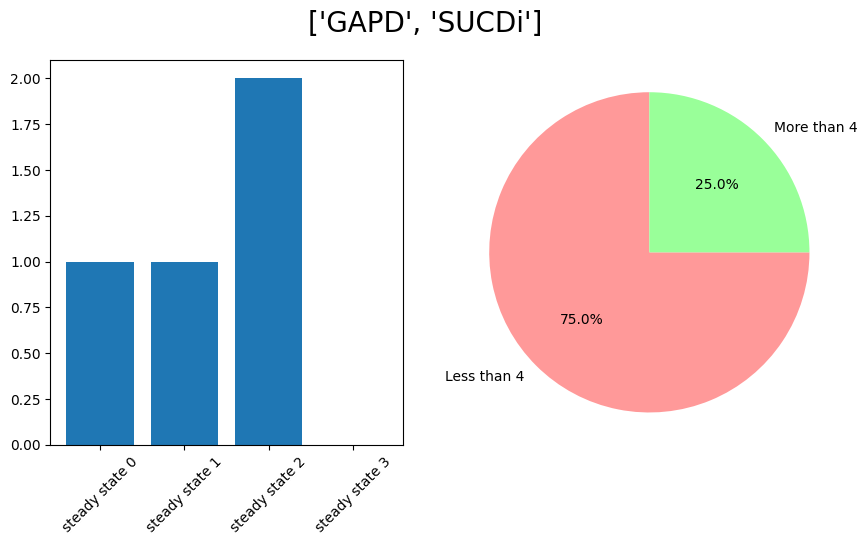

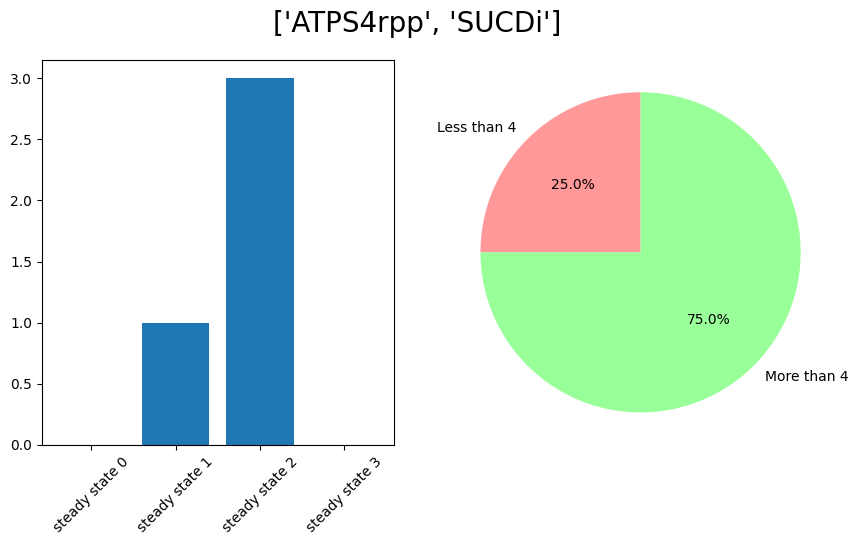

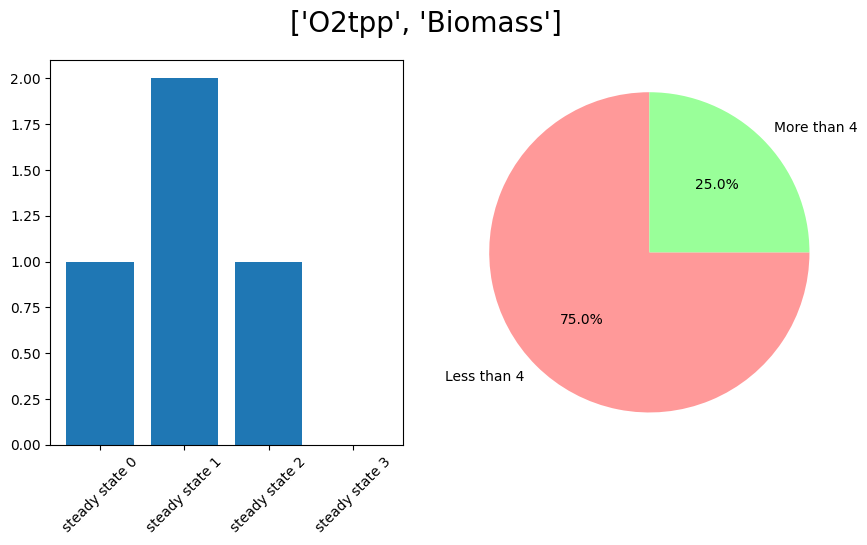

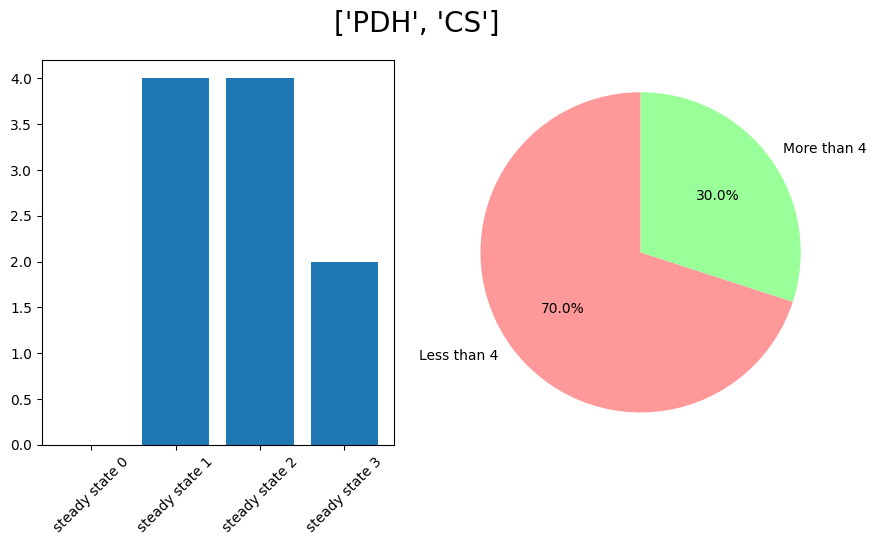

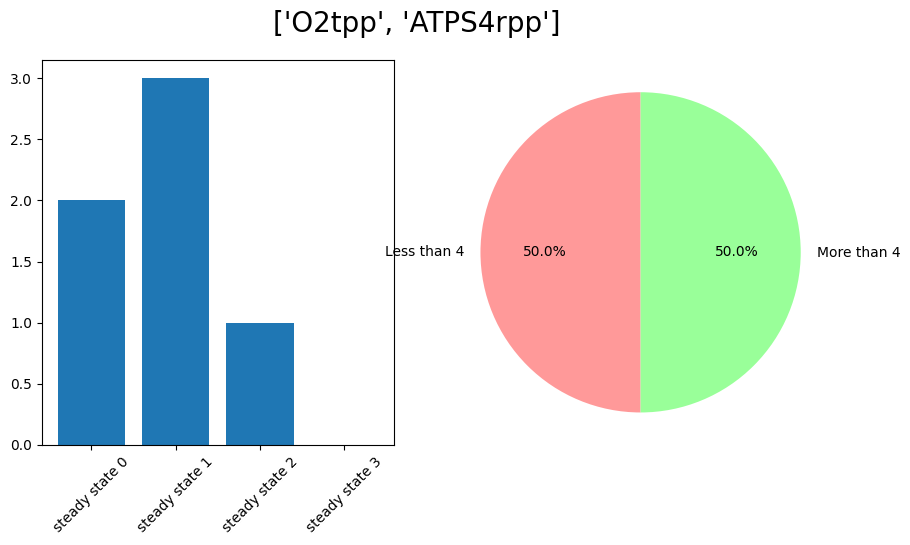

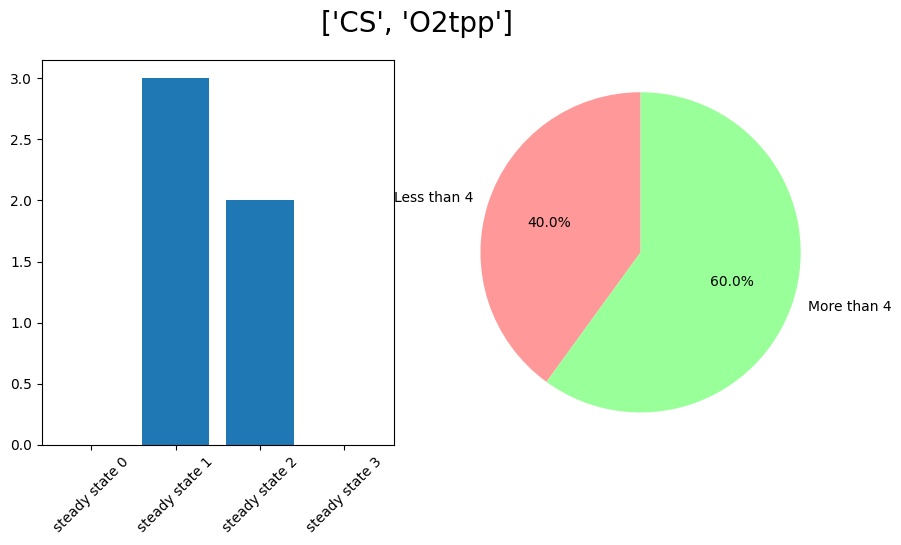

In [419]:
data = co_occurence_data
labels = ['Less than 4',  'More than 4']
for ix in range(len(data)):

    [this_pair, occurrences, tau_maxs] = co_occurence_data.loc[ix].values

    if len(tau_maxs)!=0:  
        plt.figure(figsize = (10,5))
        plt.subplot(121)
        plt.bar(x = np.arange(len(occurrences)), height = occurrences)
        plt.xticks(np.arange(len(occurrences)), [f'steady state {i}' for i in range(len(occurrences))], rotation = 45)
    
    
        # Plot pieplot of associated dynamics
        sublist = tau_maxs
        taus = [sum(1 for x in sublist if x < 4), sum(1 for x in sublist if x > 4)]
    
        plt.subplot(122)
        plt.pie(taus, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#99ff99'])
        plt.axis('equal')  # Equal aspect ratio ensures that pie chart is drawn as a circle
        
        plt.suptitle(f'{this_pair}',  fontsize = 20)
        plt.show()
        plt.close()